In [1]:
'''
I need to put these through PCA

Notes:

- Take a look at clusters with declining populations
- Set a K-means seed
- Clicky plots (plotly)
- Next move should be comparative phylogenetic methods where i use a Tree as my predictor/null
    and my curve cluster groupings as a test/actual
    - Then I will try to see if any other traits like body size, climate, lat/lon are better predictors than the null
- Consider the fact that samples in the same time series cluster may not be the most similar in terms of read data
    - Assert this assumption by maybe checking BLAST scores between sequences within the same cluster
- Add feature that might search web for each species in cluster list in order to 
    create a heatmap of the world (choropleth) for hits of the species' natural habitat
    - Exploratory analysis tool
- Read Ricky D's MSMC Paper
- Some samples have abnormally large Ne's 
- For the larger datasets, omitting noisy front points seems to make the 
ts curve distribution more uniform


Issues:

- Chack out how more reasonable orders (not Passeriformes) fall into clusters
- Check out how families that have >1 sample cluster (if they do)
- Phylogeny null model and MSMC test future idea
- Web app interface for clustering, sample classification, and post clustering analysis
- Form scatter plots from relevant histograms (use em as components basically) of distributions to better identify which samples were filtered and how they fit spacially like a PCA
- Identify significant points labeled by dtw clustering, might better visuallize HOW clusters are made
    - If I can get the scoring matrix and traceback for optimal path, I might be able to draw line or
        map how pairs of curves were aligned (alignment corresponds with significant points)
        - Check: https://tslearn.readthedocs.io/en/stable/auto_examples/metrics/plot_dtw.html
            - Path and cdist_dtw seem like promising methods
        - !!! Might not be worth checking out as DTW alignment only considers 2 curves at a time -> Too much clutter
- Really consider the chloropleth for visualizing samples/clusters geographically. Might give hints at plausible historical reasons for Cluster shapes and why clusters were formed
    - Recall Russ saying that we might assume these clusters mean nothing, let's find meaning to them
- Find more appropriate way to compare PCA with and without DTW, current way uses 
  scatterplots based on default K means which is not good
- plot_curve_clusters(): Plot barycentric avg instead of arithmetic avg in red
- Classification task: Might be done already with TimeSeriesKMeans methods: fit_predict or predict 

Resolved kinda:

- Try partitioning msmc interval files in the FOF into subsets randomly and see if partitioned FOFs output similar loooking curves when MSMC'd
    - Similar seq partition curves stemming from the same awould be a good result
    - Randomly partition .fof file into 2
    - Run MSMC on .fofs
        - Edit snakemake pipeline?
- Erik and Russ think flat/weird curves are from bad data quality
- Come up with a list of weird curves, verify their quality and then do filtering
- Weirdness
    - Not many unique values
    - Low variablility
    - Unreasonable Ne valuesSource code with documentation
- Currently assuming all samples belong to UNIQUE SPECIES
- This is a neat analysis since it doesn't take too much compute power
- See Erik's PDF for mammal samples, use data like NCBI Accessions and Biosample to find SRA Accessions
    - Then form a csv to put through data collection pipeline
        - See Erik's Slack messages

- Ask Erik what unusual curves mean
    - Are they just a side effect of poor quality?
- Figure out why some MSMC curves occur with long straight lines
    - Typical MSMCs are way more chaotic
    - If no answer can be found, ask Erik about the quality of the sequencing data
    - Might need to remove data if there is really some with poor quality 
        - Erik did mention that the data comes from scaffolds
- Cluster series curves on Ne and real time (I think, GOTTA CONFIRM LATER)
- Fix subplots and maybe get a uniform view on them (for ease of comparison)
- Current state of class isn't even making dfs of uniform length (should be easy fix)
- Try to clean data points on extrema of series'
- cluster_curves(): Use of cleanSeries is not needed if I just drop unused 
  columns from mySeries in Msmc_clustering
- Very non uniform lengths (We need uniform lengths to cluster)
    - Potentially fill in empty dates with np.nan like in example (subset data already implies the last point goes to inf)
      and make each curve on the range of the longest curve
    - Potentially normalize each curve on a range [0, 1]
- Dromas_ardeola_GCA_013398915.1_msmc2.default.final has 32 of the usual 64 datapoints
- Curves are in steps. Should I interpolate curves into many points?
    - For now, just try clustering by the points as is
- Upload a txt of which clusters samples got placed in 
- Does it bother me that clusters aren't clustering similar looking curves?
    - Yea
    - It is also weird that there is a ton of variance in big clusters
- What do good NE curves even look like?
- Come up with a list of samples which give bad curves and send em to Erik
- Try normalizing curves
- Ask Erik why some real time curves don't reach 0 years in the past for x axis
- Figure out best number of clusters to use
- Can show tables for clusters
    - Look into the outlier cluster species and try to determine if results are biologically sound
    - Look into species of good clusters and determine likely cause of similar coalescence history
'''

# !pip install MiniSom
!pip install tslearn
!pip3 install geopandas
!pip3 install Shapely
# !sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

import os
import csv
import math
import zipfile
# Essential Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
import geopandas as gpd

from shapely.geometry import Point
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
# Algorithms
# from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans, KShape
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

from zipfile import ZipFile
# Mount to nipchan@uscs.edu drive
# print(os.listdir())
from google.colab import drive
# drive.mount("/content/drive")
# print(os.listdir())
if "drive" in os.listdir():
    os.chdir("drive/MyDrive/MSMC-Curve-Analysis/") # Made a directory in home Drive called "data"
np.seterr(divide = "ignore")

# Unzip data in dir
# !unzip subset.zip
# !unzip final.zip 
# print(os.listdir("subset"))
# !unzip reruns.zip -d new_final
# !unzip final.zip -d new_final
# import shutil
# path = "new_final"

# os.chdir(path)
# dirs = os.listdir()
# for dir in dirs:
#     for fileName in os.listdir(dir):
#         if ".txt" in fileName:
#             shutil.move(dir+"/"+fileName, ".")
# os.chdir("..")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.8/875.8 KB 13.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 17.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [ ]:
os.listdir("msmc_curve_data")

['mammals_part_1', 'birds_part_1', 'birds_part_2']

In [ ]:
os.listdir()

['MSMC-Exploratory-Analysis',
 'zips',
 'generation_lengths',
 'msmc_curve_data',
 'msmc_meta_data',
 'Todo.gdoc']

In [ ]:
'''
Keep zip files with MSMC curve data in "zips"
Unload MSMC curve data into "msmc_curve_data"
Ensure that data to unzip doesn't include junk 
directories
'''

for zipp in os.listdir("zips"):
    if ".zip" in zipp:
        name = zipp[:-4]
        print("zips/"+zipp,)
        with ZipFile("zips/"+zipp, "r") as zipf:
            zipf.extractall(f"msmc_curve_data/{name}")
        zipf.close()
# _MACOSX is inadvertantly brought into this world
!rm -rf msmc_curve_data/__MACOSX 
'''
For subdirs in msmc_curve_data dir, create CSVs to map each file in subdirs to a 
taxanomical class. Needed for conversion of MSMCs curves into real time. 

I can automate this by pulling species name stuff from samples, or I can just
go with the assumptions that folders will contain files of only 1 tax class
'''



zips/birds_part_1.zip
zips/birds_part_2.zip
zips/mammals_part_1.zip


'\nFor subdirs in msmc_curve_data dir, create CSVs to map each file in subdirs to a \ntaxanomical class. Needed for conversion of MSMCs curves into real time. \n\nI can automate this by pulling species name stuff from samples, or I can just\ngo with the assumptions that folders will contain files of only 1 tax class\n'

In [ ]:
os.listdir()

['MSMC-Exploratory-Analysis',
 'zips',
 'generation_lengths',
 'msmc_curve_data',
 'msmc_meta_data',
 'Todo.gdoc']

In [2]:
from numpy.ma.core import nonzero
# Reconstruct this into a class
def manual_msmc2realtime(series_name:"str", mu_type:"str", ) -> "pd.series":
    '''
    Transform MSMC curve pd.df into real time 
    '''
    s1 = cluster_rt.seriesDict[series_name]
    species_name = series_name[:series_name.index("_GC")]
    mu = cluster_rt.class_mu_dict[mu_type] # Index into my convoluted ass dictionaries to get mu's for subsets of data
    # mu = self.mu # How things originally were when I was converting curves from only aves from B10K
    # Convert scaled time to real time
    s1["left_time_boundary"] = s1["left_time_boundary"]/mu # Convert to generations
    generation_time = cluster_rt.gen_time_dict[species_name]
    s1["left_time_boundary"] = s1["left_time_boundary"] * generation_time
    # Convert Coalescence Rate to Ne
    s1["lambda"] = 1/s1["lambda"] # Take inverse of coalescence rate
    s1["lambda"] = s1["lambda"]/(2*mu)

    return s1

class Msmc_clustering():
    def __init__(self, 
                 directory, 
                 mu = None, 
                 generation_time_path = None, 
                 real_time = False, 
                 normalize_lambda = False, 
                 log_scale_time = False, 
                 plot_on_log_scale = False, 
                 uniform_ts_curve_domains=False, 
                 to_omit=[], 
                 exclude_subdirs=[], 
                 manual_cluster_count=False,
                 algo="kmeans"):
        np.random.seed(31415) # Set constant random seed, could also use random_state when creating tslearn.clustering.TimeSeriesKMeans object
        # np.random.seed only works because all packages pretty much use it, next time use random_state
        '''
        Class for clustering MSMC Curves (Ne curves). Enables options for how to 
        filter/clean data, which metrics from MSMC curves to cluster on



        Inputs:
        1.) String of directory to read in. Should end with "/". 
        2.) Mutation rate used for MSMC files
        3.) Name of file containing used generation times for each MSMC file

        log_scale_time: If enabled, actual time column in series data is log10 scaled.
        - If plot_on_log_scale is also enabled with log_scale_time, x and y labels 
          should automatically match plots and plots should not forcibly convert
          x values to log scale.
          - plot_curve_clusters()
          - plot_curve()

        Object contains
        1.) Mutation rate used for msmc data
        2.) List of dataframes (series), where each df is data from a file in directory - from read_file
        3.) List of the names corresponding to each df (file in directory) - from read_file
        4.) Set of unique series lengths (Used for cleaning purposes/uniformity) - from read_file
        5.) List of series lengths (Used for cleaning purposes/uniformity) - from read_file
        6.) Int for number of files read in - from mySeries
        7.) List of clustering labels assigned to each file (Order specific, not good to sort)
        8.) Int of clustering categories

        '''
        self.manual_cluster_count = manual_cluster_count
        self.mu = mu # Possible that files use different mutation rates

        # In the future, just read these with a txt file or something
        self.subdir_class_dict = {
            "birds_part_1":"aves",
            "birds_part_2":"aves",
            "mammals_part_1":"mammals",
            "Archive":"mammals"
        }

        self.class_mu_dict = {
            "aves" : 1.4e-9,
            "mammals" : 2.2e-9
        }
        self.algo = algo

        self.subdir2file_dict = {subdir:[] for subdir in self.subdir_class_dict.keys()}

        

        self.gen_time_dict = self.read_gen_times(generation_time_path) # keys are latin names delim by "_" instead of " "
        self.real_time = real_time
        self.normalize_lambda = normalize_lambda # Either normalize lambda or make lambda on log10 scale
        if self.real_time:
            self.plot_on_log_scale = True
            self.log_scale_time = True
        else:
            self.plot_on_log_scale = plot_on_log_scale
            self.log_scale_time = log_scale_time 
            
        self.to_omit = to_omit # List of file names to omit
        # self.mySeries, self.namesofMySeries share the same order
        self.mySeries, self.namesofMySeries, self.series_lengths, self.series_lengths_lists = self.read_file(directory, real_time, exclude_subdirs)
        self.filter_data(uniform_ts_curve_domains)
        self.normalize()
        self.seriesDict = {name : self.mySeries[idx] for idx, name in enumerate(self.namesofMySeries)}
        # self.filter_data() # Call method to filter data
        
        self.lenMySeries = len(self.mySeries)
        # These None attributes are filled with sequential calls to PCA methods
        self.dtw_labels = None # Will be list of labels for how curves are clustered
        self.cluster_count = None
        self.clusterTable = None
        self.latin_names = None
        self.km = None
        self.elbow_data = None
        self.clustering_data = None # From cleanSeries arrays used for clustering 
        
        if self.real_time:
            if self.normalize_lambda:
                if self.plot_on_log_scale:
                    self.suptitle = 'Effective Population Size Time Series Curves'
                    self.xlabel = "Real Time in Years (log10)"
                    self.ylabel = "Effective Population Size (Normalized to [0, 1])"
                else:
                    self.suptitle = 'Effective Population Size Time Series Curves'
                    self.xlabel = "Real Time in Years "
                    self.ylabel = "Effective Population Size (Normalized to [0, 1])"   
            else:
                if self.plot_on_log_scale:
                    self.suptitle = 'Effective Population Size Time Series Curves'
                    self.xlabel = "Real Time in Years (log10)"
                    self.ylabel = "Effective Population Size (1E4)"
                else:
                    self.suptitle = 'Effective Population Size Time Series Curves'
                    self.xlabel = "Real Time in Years "
                    self.ylabel = "Effective Population Size (1E4)"   
        else:
            self.suptitle = 'Coalescence Rate Time Series Curves'
            self.xlabel = "Scaled Time (left_time_boundary)"
            self.ylabel = "Scaled Coalescence Rate (lambda)"



    def read_file(self, directory, real_time, exclude_subdirs = []):
        '''
        Assuming that given directory contains subdirs full of separate MSMC curves,
        go through each subdir in directory and read each file in subdir as a pd.df.

        each subdir may have a specific mu or generation time

        Input:
        1.) String of directory to read in. Should end with "/". 

        Outputs:
        1.) List of dataframes (series)
        2.) List of the names corresponding to each df 
        3.) Set of unique series lengths 
        4.) List of series lengths
        '''
        mySeries = []
        namesofMySeries = []
        # print(self.to_omit)
        for subdir in os.listdir(directory): # There is an assumption that each subdir has its own mu since each subdir has corresponded to a single tax-class
        # Dependence of my on assumption that files in a subdir are of the same class can be circumvented if I just have a mapping between filenames and tax-classes
            # print(subdir+"/")
            if subdir not in exclude_subdirs:
                for filename in os.listdir(directory+subdir+"/"): # depending on filename's taxanomical class, mu may vary
                    if filename.endswith(".txt"):
                        if filename[:-4] not in self.to_omit:
                            # print(directory+subdir+"/"+filename)
                            df = pd.read_csv(directory+subdir+"/"+filename, sep='\t')
                            # While we are at it I just filtered the columns that we will be working on
                            df.set_index("time_index",inplace=True)
                            # set the date columns as index
                            df.sort_index(inplace=True)
                            # and lastly, ordered the data according to our date index
                            mySeries.append(df)
                            namesofMySeries.append(filename[:-4])
                            self.subdir2file_dict[subdir].append(filename)
                            if real_time: # If real time curves are desired, transform current df
                                mu = self.class_mu_dict[self.subdir_class_dict[subdir]] # Index into my convoluted ass dictionaries to get mu's for subsets of data
                                # mu = self.mu # How things originally were when I was converting curves from only aves from B10K
                                # Convert scaled time to real time
                                df["left_time_boundary"] = df["left_time_boundary"]/mu # Convert to generations
                                for key in self.gen_time_dict.keys(): # Step can be improved if keys list is sorted
                                    if key in filename:
                                        generation_time = self.gen_time_dict[key]
                                        df["left_time_boundary"] = df["left_time_boundary"] * generation_time
                                # Convert Coalescence Rate to Ne
                                df["lambda"] = 1/df["lambda"] # Take inverse of coalescence rate
                                df["lambda"] = df["lambda"]/(2*mu)

        series_lengths = {len(series) for series in mySeries} # Compile unique Series lengths
        series_lengths_list = [len(series) for series in mySeries] # Compile unique Series length
        return mySeries, namesofMySeries, series_lengths, series_lengths_list

    def read_gen_times(self, directory: "str") -> "dict":
        '''
        Possibly better to read generation times data after reading in MSMC curves
        whenever number taxa generation times > ts curves available

        For each file in directory, reads in a two column txt file and returns a dict where keys are 
        sample-taxa name and values are generation times (years/generation) used
        for generating MSMC curves for each sample-taxa. Strong assumption that
        1st col is for sample-taxa names and 2nd col is for generation times

        Dict use:
        If file name has a dict key within it, use that key's value as a generation 
        time
        '''
        if directory:
            gen_time_dict = dict()
            genLenFile = os.listdir(directory)
            for glf in genLenFile:
                fileLen = 0
                duplicateEntries = 0
                with open(directory+glf, "r") as myfile:
                    next(myfile) # Assuming that first line in generation times file are labels
                    for idx, line in enumerate(myfile):
                        pair = line.split("\t")
                        # print(pair)
                        key = pair[0] # taxa name
                        val = float(pair[1]) # generation time
                        gen_time_dict[key] = val
                        fileLen += 1
                        if fileLen - len(list(gen_time_dict.keys())) > duplicateEntries:
                            print(f"Duplicate gen time entry for taxa: {key} at line {idx}")
                            duplicateEntries += 1
                    print(f"fileLen: {fileLen}\nduplicate entries: {duplicateEntries}")
            return gen_time_dict
        else:
            return None



    def filter_data(self, uniform_ts_curve_domains=False):
        '''
        First part takes in a group of series and scales their time ranges to 
        the series with the oldest date.

        Inputs:
        1.) Set of unique series lengths
        2.) List of series lengths 
        3.) Option for scaling 
        '''
        # Record sizes and lengths of series'
        # if scaled_to_real: # Scale data to real time and eff. pop. sizes

        # Only use series' of the longest known length
        max_series_len = max(self.series_lengths)

        newMySeries = []
        newNamesOfMySeries = []
        for idx, series in enumerate(self.mySeries):
            if len(series) == max_series_len:
                if series["left_time_boundary"].iloc[0] == 0: # If 1st time entry is 0

                    # print(f"len of trimmed df: {len(series.iloc[1:])}")
                    newMySeries.append(series.iloc[1:]) # Clip off 1st entry to avoid -inf err when scaling to log10 scale in normalize()
                    # Entry at 0th and 1st idx are identical for lambda so no meaningful info should be lost
                else:
                    newMySeries.append(series)
                newNamesOfMySeries.append(self.namesofMySeries[idx])
        self.mySeries = newMySeries
        self.namesofMySeries = newNamesOfMySeries
        
        # Find largest final time plotted among series
        # Make sure all series' are on the range of the series of the largest size (biggest final time recorded on X-axis)
        # This should be fine since all times boundaries are implied to end on inf anyways (found in original data)

        if uniform_ts_curve_domains:
            ts_beginning_time = {series["left_time_boundary"].max() for series in self.mySeries} # units in terms of max(series) (Time)
            ts_beginning_time = max(ts_beginning_time)
            to_extend_idxs = [] # Record series' which had final recorded times less that biggest final time
            for i in range(len(self.mySeries)):
                if max(self.mySeries[i]) != ts_beginning_time: # If series doesn't extend to oldest time series beginning time
                    to_extend_idxs.append(i)
            for idx in to_extend_idxs: # Scale time boundaries of each series to the oldest known one in all data
                self.mySeries[idx]["left_time_boundary"].iloc[-1] = ts_beginning_time

    def normalize_series(self, series: "pd.series") -> "pd.series":
        '''
        Normalize a pandas series (df or col) to [0, 1]
        '''
        # print("Normalizing")
        return (series - series.min())/(series.max() - series.min())

    def normalize(self):
        '''
        Transform time column into log10 scale [BAD]
            - Due to use of DTW, using a log10 transform exponentially decreases
              the difference (time) between data points as ts curve will be in terms
              of magnitude rather than time
            - Instead, maybe forget about log10 transform except when it comes to plotting
        Don't 
        and either
        (1) Normalize lambda column to [0, 1]
        (2) Divide lambda column by 1e4
        '''
        for idx in range(len(self.mySeries)):
            if self.log_scale_time:
                self.plot_on_log_scale = True  
                self.mySeries[idx]["left_time_boundary"] = np.log10(self.mySeries[idx]["left_time_boundary"])
            if self.normalize_lambda:
                self.mySeries[idx]["lambda"] = self.normalize_series(self.mySeries[idx]["lambda"])
            else:
                pass

    def plot_series(self, num_to_plot=None, cols=5, fs_x=50, fs_y=25):
        '''
        Plots curves for mySeries dfs as they are in current object. By default
        mySeries dfs may only be in terms of Scaled time and Coalescence Rate

        Inputs:
        1.) Int of plots to make
        2.) Int of columns for figure
        '''
        if not num_to_plot: # If no number of plots is specified
            num_to_plot = self.lenMySeries # Number of plots to plot is set to the number of files read in
        # rows = (num_to_plot//cols) + 1 # Find number of rows for figure
        if num_to_plot%cols > 0:
            rows = (num_to_plot//cols) + 1 # Find number of rows for figure
        else:
            rows = (num_to_plot//cols)
        fig, axs = plt.subplots(rows, cols, figsize=(fs_x, fs_y)) # MPL subplot
        fig.suptitle(self.suptitle) # Figure super title

        for i in range(rows):
            for j in range(cols):
                if i*cols+j+1 > len(self.mySeries): # pass the others that we can't fill
                    continue
                curr = self.mySeries[i*cols+j]
                x_list = curr.left_time_boundary.to_numpy()
                y_list = curr["lambda"].to_numpy()
                axs[i, j].step(x_list, y_list, 'g-', where="pre")
                axs[i, j].set_title(self.namesofMySeries[i*cols+j])  
                axs[i, j].set_xlabel(self.xlabel) # time
                axs[i, j].set_ylabel(self.ylabel) # size
        fig.patch.set_facecolor('white') # Changes background to white
        plt.show()

    def elbow_method(self, low=5, high=20, save_to=None):
        '''

        Usage ex: 
        figures_path = "MSMC-Exploratory-Analysis/results/figures/"
        instance.elbow_method(save_to=figures_path)
        '''
        fig = plt.figure()
        elbow_data = []
        cleanSeries = [series.drop(["right_time_boundary"], axis=1) for series in self.mySeries]
        for n_clusters in range (low, high):
            # km = TimeSeriesKMeans(n_clusters=n_clusters, verbose=False, metric="dtw", dtw_inertia=True, random_state=205)
            # km = KShape(n_clusters=n_clusters, verbose=False, random_state=205) 
            if self.algo == "kmeans":
                km = TimeSeriesKMeans(n_clusters=n_clusters, verbose=False, metric="softdtw", metric_params={"gamma": .5}, dtw_inertia=True, random_state=205)
            elif self.algo == "kshapes":
                km = KShape(n_clusters=n_clusters, verbose=False, random_state=205) 
            y_pred = km.fit_predict(cleanSeries)
            elbow_data.append((n_clusters, km.inertia_))
        ax = pd.DataFrame(elbow_data, columns=['clusters', 'distance']).plot(x='clusters', y='distance')
        self.elbow_data = elbow_data
        ax.set_ylabel("Distortion in Sum of squared distances (Inertia)")
        if save_to:
            plt.savefig(save_to + "cluster-related-figures/elbow-method-plot.png", dpi=300)
        plt.show()
        return 


    def cluster_curves(self, uniform_ts_curve_domains=False, omit_front=0, omit_back=0, cols=3, fs_x=25, fs_y=50, save_to=None, save_name="cluster-related-figures/curve-clusters.png", omit_time_feature=False, metric_params={"gamma": .5}):
        '''
        MAIN FUNCTION TO CALL FOR PLOTTING. Calls other methods to function.

        Clusters dataframes with K means using DTW.
        Plots dataframe curves (MSMC curves) within their assigned clusters.
        Plots 2 PCA scatterplots comparing how 
        1.) K means using DTW 
        2.) K means using
        clustered dataframe curves (MSMC curves)
        '''
        # Form a list of dfs to cluster

        cleanSeries_with_df = [series.drop(["right_time_boundary"], axis=1) for series in self.mySeries] # List of dfs with only the desired 2 columns


        print(f"cleanSeries_with_df: {len(cleanSeries_with_df)},")
        print(f"mySeries: {len(self.mySeries)}")
        print(f"mySeries: {len(self.mySeries[0])}")

        cleanSeries_with_df = [series[omit_front: max(self.series_lengths) - omit_back] for series in cleanSeries_with_df] # Omit certain number of datapoints from front (end time) and back (beginning time) of ts curve
        cleanSeries = np.array(cleanSeries_with_df)
        # After checking how clusters are formed when omitting time data, worse clusters will form
        if omit_time_feature: # Enable only if you want to exclude time interval info from clustering
            cleanSeries = cleanSeries[:,:,1] 
        print(f"Plotting {len(cleanSeries[0])}/{max(self.series_lengths)}")
        print(f"Omitting {omit_front} points from front and {omit_back} from back")
        if self.manual_cluster_count:
            self.cluster_count = self.manual_cluster_count
        else:
            self.cluster_count = math.ceil(math.sqrt(len(cleanSeries)))
        # print(f"len(cleanSeries): {len(cleanSeries)}\nCluster count: {self.cluster_count}")
        # Cluster using dtw 
        print(self.algo)
        if self.algo == "kmeans":
            self.km = TimeSeriesKMeans(n_clusters=self.cluster_count, 
                                  verbose=False, 
                                  metric="softdtw", 
                                  metric_params={"gamma": .5}, 
                                  dtw_inertia=True, 
                                  random_state=205)
        # Cluster using kshapes algorithm
        elif self.algo == "kshapes":
            self.km = KShape(n_clusters=self.cluster_count, 
                        verbose=False, 
                        random_state=205) 
            print(type(self.km))
        self.dtw_labels = self.km.fit_predict(cleanSeries) # km.fit_predict is fit on a 2 column df (BEWARE OF NON UNIFORM SERIES')
        # Plots curves within their assigned clusters
        self.plot_curve_clusters(cleanSeries_with_df, cols, fs_x, fs_y, save_to = save_to, save_name = save_name) 
        # Plots distribution of curves among the clusters created with dtw
        self.plot_cluster_distr(save_to=save_to, save_name = "distr_" + save_name)
        # fancy_names_for_labels = [f"Cluster {label}" for label in self.dtw_labels] # List of cluster names
        # # Plot PCA scatterplot with DTW labels
        # self.plot_PCA(cleanSeries)
        # # Plot PCA scatterplot with DTW labels
        # self.plot_PCA(cleanSeries, labels=True)
        self.clusterTable = {self.namesofMySeries[i] : self.dtw_labels[i] for i in range(len(self.dtw_labels))}
        print(f"sample len: {len(self.namesofMySeries)}")
        print(f"label len: {len(self.dtw_labels)}")
        data = {"Sample": self.namesofMySeries, "Labels": self.dtw_labels}
        self.clusterTable = pd.DataFrame.from_dict(data, orient="columns")
        self.add_latin_to_cluster()
        self.clustering_data = cleanSeries_with_df
        


    def plot_curve_clusters(self, cleanSeries, cols=3, fs_x=25, fs_y=50, save_to = None, save_name="cluster-related-figures/curve-clusters.png"):
        '''
        Plots curves within their clusters assigned from K means using DTW

        Dark Grey region is Last Glacial Period
        Light Grey region is Pleistocene
        '''
        # Necessary for plotting figure subplots (square shape), nothing else
        # plot_count = math.ceil(math.sqrt(self.cluster_count)) 
        num_to_plot = self.cluster_count # Set no. plots to the no. of clusters
        print(f"num to plot : {num_to_plot}")
        if num_to_plot%cols == 0:
            rows = (num_to_plot//cols)
        else:
            rows = (num_to_plot//cols) + 1
        print(f"curve cluster plot shape: ({rows}, {cols})")
        fig, axs = plt.subplots(rows, cols, figsize=(fs_x, fs_y))
        if self.algo == "kmeans":
            fig.suptitle(f'DTW Clusters of {self.suptitle}')
        else:
            fig.suptitle(f'{self.algo} Clusters of {self.suptitle}')
        plt.rcParams["figure.facecolor"] = 'white'

        row_i=0
        column_j=0
        # Plot curves with their cluster according to their label
        for idx_l, label in enumerate(set(self.dtw_labels)): # For each unique/possible label
            x_cluster = []
            y_cluster = []
            for i in range(len(self.dtw_labels)): # For each curve's label
                    if self.dtw_labels[i]==label: # match it to the current unique/possible label focused on
                        if self.plot_on_log_scale and not self.log_scale_time:
                            x = np.log10(cleanSeries[i]["left_time_boundary"].to_numpy()) # Index mySeries for df
                        else:
                            x = cleanSeries[i]["left_time_boundary"].to_numpy()
                        y = cleanSeries[i]["lambda"].to_numpy()


                        # Curve color assignment
                        if self.namesofMySeries[i]+".txt" in self.subdir2file_dict["Archive"]: # Color Archive files differently (mammals)
                            reg_curve_color = "green" 
                        elif self.namesofMySeries[i]+".txt" in self.subdir2file_dict["birds_part_2"]:
                            reg_curve_color = "gray" 
                        elif self.namesofMySeries[i]+".txt" in self.subdir2file_dict["birds_part_1"]:
                            reg_curve_color = "gray" 

                        if rows == 1: # If axs only takes 1D indices
                            axs[column_j].step(x, y, "+-", c=reg_curve_color, alpha=0.4)
                            
                        else:
                            axs[row_i, column_j].step(x, y, "+-", c=reg_curve_color,alpha=0.4)
                        x_cluster.append(x)
                        y_cluster.append(y)
            if len(x_cluster) > 0:
                # X = dtw_barycenter_averaging(x_cluster, y_cluster)
                x_avg = np.average(x_cluster, axis=0)
                y_avg = np.average(y_cluster, axis=0)
                y_sd = np.std(y_cluster, axis=0)


                # li = self.km.cluster_centers_[idx_l]
                # li = sorted(li, key= lambda x:x[0]) # Attempt to fix weird DTW-induced loops in DBA curve
                # xs = [x[0] for x in li]
                # ys = [x[1] for x in li]

                if rows == 1: # If axs only takes 1D indices
                    axs[column_j].step(x_avg ,y_avg, "+-", c="magenta", label="Arithmetic mean") # Arithemtic avg of curves plotted in magenta
                    axs[column_j].step(x_avg ,y_avg-y_sd, "+--", c="blue", label="Arithmetic SD Lower") 
                    axs[column_j].step(x_avg ,y_avg+y_sd, "+--", c="blue", label="Arithmetic SD Upper") 

                    # axs[column_j].step(xs, ys, "+-", label="DTW Barycentric avg") # DBA line which DTW uses as centroids for clustering
                    axs[column_j].set_title("Cluster "+ str(column_j + (row_i*cols)) )
                    axs[column_j].set_xlabel(self.xlabel)
                    axs[column_j].set_ylabel(self.ylabel)
                    if self.real_time: # Here is where to edit for differentiating curves by color
                        axs[column_j].axvspan(4, 5, alpha=0.5, color='grey')
                        axs[column_j].axvspan(5, 6.3, alpha=0.25, color='grey')
                        # axs[column_j].set_xlim(4, 7.5)
                else: 
                    axs[row_i, column_j].step(x_avg ,y_avg, "+-", c="magenta", label="Arithmetic mean") # Arithemtic avg of curves plotted in magenta
                    axs[row_i, column_j].step(x_avg ,y_avg-y_sd, "+--", c="blue", label="Arithmetic SD Lower") 
                    axs[row_i, column_j].step(x_avg ,y_avg+y_sd, "+--", c="blue", label="Arithmetic SD Upper") 

                    # axs[row_i, column_j].step(xs, ys, "+-", c="red", label="DTW Barycentric avg") # DBA line which DTW uses as centroids for clustering
                    axs[row_i, column_j].set_title("Cluster "+ str(column_j + (row_i*cols)) )
                    axs[row_i, column_j].set_xlabel(self.xlabel)
                    axs[row_i, column_j].set_ylabel(self.ylabel)
                    if self.real_time:
                        axs[row_i, column_j].axvspan(4, 5, alpha=0.5, color='grey')
                        axs[row_i, column_j].axvspan(5, 6.3, alpha=0.25, color='grey')
                        # axs[row_i, column_j].set_xlim(4, 7.5)
            
            column_j+=1 # Increment subplot column
            if column_j == cols:
                row_i+=1
                column_j=0
        if save_to:
            plt.savefig(save_to + save_name, dpi = 300)
        plt.show()

    def plot_cluster_distr(self, save_to=None, save_name="curve-clusters.png"):
        '''
        Plots histogram to illustrate distribution of curves among the clusters 
        created with dtw
        '''
        cluster_c = [len(self.dtw_labels[self.dtw_labels==i]) for i in range(self.cluster_count)]
        cluster_n = ["Cluster "+str(i) for i in range(self.cluster_count)]
        plt.figure(figsize=(15,5))
        plt.title(f"Cluster Distribution for {self.algo}")
        plt.bar(cluster_n,cluster_c)
        if save_to:
            plt.savefig(save_to + save_name, dpi = 100)
        plt.show()

    def plot_PCA(self, cleanSeries, labels=False):
        '''
        Plots a PCA scatterplot with either regular K means labels or 
        K means labels using DTW.
        '''
        pca = PCA(n_components=2) # sklearn.decomposition PCA 
        X = [series["left_time_boundary"] for series in cleanSeries]
        Y = [series["lambda"] for series in cleanSeries]
        cleanSeries_transformed = pca.fit_transform(X, Y) # Performs PCA
        kmeans = KMeans(n_clusters=self.cluster_count, max_iter=5000) # sklearn.cluster KMeans 
        if not labels: 
            labels = kmeans.fit_predict(cleanSeries_transformed) # Computes PCA labels with sklearn.cluster KMeans
        else:
            labels = self.dtw_labels # Use curve clusters from k means with DTW
        
        plt.figure(figsize=(20, 5))
        plt.title(f"PCA of MSMC Curves (labels={labels})")
        plt.scatter(cleanSeries_transformed[:, 0], cleanSeries_transformed[:, 1], c=labels, s=300)
        plt.show()

    def plot_curve(self, name=None, df = None, dir = None, dups=0, stretch=0, err=0, thresh_min=None, thresh_max=None, winStart=None, winEnd=None, fs_x=10, fs_y=10, xlim_start=None, xlim_end=None, ylim_start=None, ylim_end=None,  save_to = None, additional_info=None, plot_on_log_scale=True):
        '''
        Plots series curve given name, df, or dir of series
        Option to save plot to a directory
        '''
        # plt.rcParams["figure.facecolor"] = 'white'
        plt.figure(figsize=(fs_x, fs_y))

        if xlim_start and xlim_end:
            plt.xlim(xlim_start, xlim_end)
        if ylim_start and ylim_end:
            plt.ylim(ylim_start, ylim_end)
        

        if name:
            idx = self.namesofMySeries.index(name)
            series = self.mySeries[idx]
        elif dir:
            df = pd.read_csv(dir, sep='\t')
            # While we are at it I just filtered the columns that we will be working on
            df.set_index("time_index",inplace=True)
            # set the date columns as index
            df.sort_index(inplace=True)
            name = dir[:dir.index(".txt")]
            series = df
        else:
            series = df

        if plot_on_log_scale and not self.log_scale_time:
            x = np.log10(series["left_time_boundary"].to_numpy()) # Index mySeries for df
            # if winStart and winEnd:
            #     winStart = np.log10(winStart)
            #     winEnd = np.log10(winEnd)
        else:
            x = series["left_time_boundary"].to_numpy()
        y = series["lambda"].to_numpy()
        plt.axvspan(4, 5, alpha=0.5, color='grey')
        plt.axvspan(5, 6.3, alpha=0.25, color='grey')
        plt.step(x, y, "+-", c="green")
        if thresh_min and thresh_max:
            plt.plot(x, [thresh_min]*len(x), "-", color="salmon")
            plt.plot(x, [thresh_max]*len(x), "--", color="red")
            
        if winStart and winEnd:
            plt.axvline(x = winStart, color="magenta", linestyle="-")
            plt.axvline(x = winEnd, color="purple", linestyle="--")
        if additional_info:
            title = f"{name} \n{dups*100:.2f}% of curve is flat.  Curve flatness threshold: >={stretch*100:.2f}%\nUsing {err*100}% error"
            for string in additional_info:
                title += string + "\n"
            plt.title(title)
        else:
            plt.title(f"{name} \n{dups*100:.2f}% of curve is flat.  Curve flatness threshold: >={stretch*100:.2f}%\nUsing {err*100}% error")
        plt.xlabel(self.xlabel)
        plt.ylabel(self.ylabel)
        # plt.show()
        if save_to:
            plt.savefig(fname=f"{save_to}/{name}.png", dpi=300)
        plt.show()

    def list_from_cluster(self, num, omit=False):
        '''
        Return a list which either keeps or omits the names of the files of cluster
        corresponding to given {num } 
        '''
        if not omit:
            boolList = [True if i == num else False for i in self.clusterTable["Labels"].tolist()]
        else:
            boolList = [False if i == num else True for i in self.clusterTable["Labels"].tolist()]
        return self.clusterTable[boolList]["Sample"].tolist()

    def cluster_from_label(self, label: "int") -> "df":
        '''
        Retrieve a single cluster from self.clusterTable as a df given a label
        '''
        boolList = (self.clusterTable["Labels"] == label).tolist()
        return self.clusterTable.iloc[boolList]

    def series_from_name(self, name):
        idx = self.namesofMySeries.index(name)
        return self.mySeries[idx]

    def add_latin_to_cluster(self):
        '''
        Adds latin names column to cluster table in order to get some sort of relational
        identifier between it and the meta data table

        Table matcher only works if original MSMC curve files had their corresponding
        GCA accession ID in their name. However this loop only uses GCA accession ID to 
        throw it out, so GCA isn't really needed to accomplish the goal of confering 
        df_meta entries over to associated clusterTable entries. It's just the simplest 
        and most efficient way to do it right now, unless I can somehow add GCA accession
        ID to the 
        '''
        latin_name_list = []
        for sample_name in self.clusterTable["Sample"]:
            try:
                cutoff_idx = sample_name.index("_GCA") # Bad, but working way to separate 
            except:
                cutoff_idx = sample_name.index("_GCF") # Bad, but working way to separate 
            latin_name = sample_name[:cutoff_idx]
            latin_name_list.append(latin_name)
        self.clusterTable["Latin name"] = pd.Series(latin_name_list)
        self.latin_names = self.clusterTable["Latin name"].tolist()
        self.clusterTable = self.clusterTable.set_index("Latin name")
        return

# Clustering on whole set

In [ ]:
# '''
# Weird curves can get wacky population sizes (above 1e7) as well as 
# long stretches of duplicate y values


# Find weird curves
# '''

# # cluster1 = Msmc_clustering(directory="subset/", mu=1.4e-9, generation_time_path='generation_times.txt', real_time=False)
# # cluster1_rt = Msmc_clustering(directory="subset/", mu=1.4e-9, generation_time_path='generation_times.txt', real_time=True)
# # cluster1.cluster_curves(omit_front=0, omit_back=0, cols=3, fs_x=50, fs_y=7) # expecting matrix of (files, lists of y values) since they assume x vals from lists of y values [ISSUE]
# # cluster1_rt.cluster_curves(omit_front=0, omit_back=0, cols=3, fs_x=50, fs_y=7) # expecting matrix of (files, lists of y values) since they assume x vals from lists of y values [ISSUE]

# '''
# Clustering with whole set of data. 
# No filtering, log scaling of time, or normalization of pop size.
# '''

# cluster_rt = Msmc_clustering(directory="msmc_curve_data/", mu=1.4e-9, 
#                              generation_time_path='generation_lengths/', 
#                              real_time=False, plot_on_log_scale=False, 
#                              log_scale_time=False, normalize_lambda=False, 
#                              exclude_subdirs=["Archive", "mammals_part_1"])
# cluster_rt.cluster_curves(omit_front=0, omit_back=0, cols=5,  fs_x=50, fs_y=25)


NE = $\frac{1}{2*mu} * \frac{1}{lambda}$
- $lambda$ is coalescent rate determined by MSMC \\
- $mu$ is mutation rate

In [ ]:
'''
9/13
!!! Get mammal generation times !!!
Cluster and plot mammals
Find mammals in omit_test_lenient
Rerun flat mammals
'''


'''
Clustering with whole set of data. 
No filtering, log scaling of time, or normalization of pop size.
'''

# cluster_mammals = Msmc_clustering(directory="msmc_curve_data/", mu=1.4e-9, generation_time_path='generation_lengths/', real_time=False, plot_on_log_scale=False, log_scale_time=False, normalize_lambda=False, exclude_subdirs=["Archive", "reruns", "final"])
# cluster_mammals.cluster_curves(omit_front=0, omit_back=0, cols=5,  fs_x=50, fs_y=25)

'\nClustering with whole set of data. \nNo filtering, log scaling of time, or normalization of pop size.\n'

#Filtering data on stretches of flattness AND sharp leaps in magnitude

In [ ]:
def longest_consecutive_stretch(boolList):
    '''
    Takes list of bools and finds longest stretch of consecutive Trues
    '''
    start = 0
    end = 0
    maxStart = 0
    maxEnd = 0
    true = False
    for idx, item in enumerate(boolList):
        if item == True:
            if true:
                end = idx+1
            else:
                start = idx
                end = idx+1
                true = True
        else:
            if true:
                true = False
                if end-start >= maxEnd - maxStart:
                    maxStart = start
                    maxEnd = end  
    if true and ((end-start) >= (maxEnd - maxStart)): # If longest stretch of Trues ends the list
        maxStart = start
        maxEnd = None
    return maxStart, maxEnd

def filter_flattness_sharpness(cluster: "Msmc_clustering", 
                       identical_val_threshold: "float" = 0.70, err : "float" = 0.01, # Args for filtering flattness
                       magnitude_jump_threshold: "float" = 0.95, points_per_jump: "int" = 3, ignore_low_mag = 0, # Args for filtering magnitude jumps
                       plot: "bool" = False, min_unique_vals=5, fs_x=8, fs_y=5, save_to_filter=None, save_to_kept=None) -> "list<str>":

    '''
    Filter out files which 
    1.) Remain flat for a long stretch of data points
    2) Record sharp leaps in magnitude over a variable number of points

    points_per_jump: 
        Number of points to for which a sharp jump can be called on.
        The larger this is, the more likely a sharp jump is to be declared.
        Smallest this can be should be 2. 

    Notes:
    - Prunella Fulvescens is filtered out with current set up, but its curve seems reasonable
    - Sharp leap in magnitude should be at least 1
    '''

    weirdCurves_rt_magnitude = [] # List will contain names (str) of all files to filter out after loop below finishes
    for idx, series in enumerate(cluster.mySeries):
        curve_height = max(series["lambda"].unique()) - min(series["lambda"].unique()) # Record the height of the curve
        # Variables for determining flattness of data points (time vs pop size) (Horizontal lines) 
        flat = False # Flag for determining flatness
        bestStretch = 0 # Set length of best recorded stretch of flat points to 0
        nameBestStretch = None # Set name of best stretch to None by default
        # Variables for determining sharpness of data points (time vs pop size) (Vertical lines) 
        sharp = False # Flag for determining sharpness
        bestMagDiff = 0 # Tracks largest difference in magnitude
        bestFirstMagnitude = 0
        bestLastMagnitude = 0
        # Horizontal line boundaries made here
        # print(series["lambda"].unique())
        for uniqueVal in series["lambda"].unique(): # Iterate over unique y values (Eff. Pop. Size)
            # Sets threshold with upper and lower bounds (WRT lambda) for which consecutive points are considered flat
            thresh_max = uniqueVal + curve_height*err
            thresh_min = uniqueVal - curve_height*err
            # Create boolean arrays where a point] is labeled as True if it is within the interval set above
            A = series["lambda"] >= thresh_min # Contains bools for items above threshold min
            B = series["lambda"] <= thresh_max # Contains bools for items below threshold max
            boolList = [x and y for x,y in zip(A, B)] # Each entry corresponds to an x on time series curve (union of A and B)
            conStart, conEnd = longest_consecutive_stretch(boolList) # Finds indices of longest consecutive stretch of vals that fit within threshold
            consecutiveBoolList = [False] * len(boolList)
            consecutiveBoolList[conStart:conEnd] = boolList[conStart:conEnd] # Finds list for the longest stretch of consecutive Trues, marks all else False
            flatSeries = series.loc[consecutiveBoolList] # Series of all entries considered flat
            if cluster.log_scale_time:
                flatTimes = flatSeries["left_time_boundary"].to_numpy()
                firstWhole = series["left_time_boundary"].iloc[0]
                lastWhole = series["left_time_boundary"].iloc[-1]
            else:
                flatTimes = np.log10(flatSeries["left_time_boundary"].to_numpy())
                firstWhole = np.log10(series["left_time_boundary"].iloc[0])
                lastWhole = np.log10(series["left_time_boundary"].iloc[-1])
            identical_val_count = len(flatSeries) # Number of points which fit in the interval
            # Only consider consecutive flat units
            firstFlat = flatTimes[0]
            lastFlat = flatTimes[-1]
            # Filter by percentage of whole curve which flat points cover
            unitsFlat = lastFlat - firstFlat # Finds length of flat parts of curve 
            unitsWhole = lastWhole - firstWhole # Finds length of whole curve
            percentFlat = (unitsFlat)/(unitsWhole)
            # Proceed only if flattness in a curve was detected
            if percentFlat > identical_val_threshold:
                if percentFlat > bestStretch: # If flattness for curve was better that previously thought
                    bestStretch = percentFlat # Set current record for the length of the best stretch of flattness
                    best_max = thresh_max
                    best_min = thresh_min
                    nameBestStretch = cluster.namesofMySeries[idx] # Record the name of the current curve which flattness was detected
                    flat = True
                    

        # Vertical line boundaries made here
        # Records the first abnormal jump in magnitude and breaks

        # Convert points_per_jump to a percentage like how flatness is detected
        # For each point, search a percentage interval to the right and see if the next point is crazy

        for i in range(len(series["lambda"]) - points_per_jump + 1):                 
            pointWindow = series["lambda"][i:i+points_per_jump].to_numpy() # Population size points in window
            # Might not make sense logically, consider size not position
            for idx_j, j in enumerate(pointWindow[1:]):
                if cluster.log_scale_time:
                    firstMagnitude = pointWindow[0]
                    lastMagnitude = j
                else:
                    firstMagnitude = np.log10(pointWindow[0])
                    lastMagnitude = np.log10(j)
                magDiff = abs(lastMagnitude - firstMagnitude)
                # print(magDiff)
                if magDiff > magnitude_jump_threshold and (max(firstMagnitude, lastMagnitude) > ignore_low_mag): # PERHAPS consider using thresholds in terms of TIME rather than ACTUAL POINTS
                    
                    if magDiff > bestMagDiff:
                        # print(f"Jump in magnitude of {magDiff} within point window of size {points_per_jump}")
                        sharp = True
                        # print("yes")
                        if cluster.log_scale_time:
                            winStart = series["left_time_boundary"].iloc[i]
                            winEnd   = series["left_time_boundary"].iloc[i+ idx_j]
                        else:
                            winStart = np.log10(series["left_time_boundary"].iloc[i])
                            winEnd   = np.log10(series["left_time_boundary"].iloc[i+ idx_j])
                        # Update info for best magnitude difference (Ne)
                        bestMagDiff = magDiff
                        bestFirstMagnitude = firstMagnitude
                        bestLastMagnitude = lastMagnitude
                        # Update info for best window to look at (Real Time)
                        best_istart = i
                        best_iend = i+idx_j
                        best_winStart = winStart
                        best_winEnd = winEnd
        num_uniques = len(series["lambda"].unique())
        if ((flat and sharp) and (num_uniques < min_unique_vals)): # If current curve met filtering criteria, filter it out
            if plot:
                additional_info = [f"; Unique vals: {num_uniques}",
                                   f"Magnitude diff: {bestMagDiff:.2} between log10(years) [{best_winStart:.4}, {best_winEnd:.4}] at pts [{best_istart}, {best_iend}] (window size {points_per_jump})"
                                   ]
                if save_to_filter:
                    cluster.plot_curve(name = nameBestStretch, dups=bestStretch, stretch=identical_val_threshold, err=err, thresh_min=best_min, thresh_max=best_max, winStart = best_winStart, winEnd = best_winEnd, fs_x=fs_x, fs_y=fs_y, plot_on_log_scale=True, additional_info = additional_info, save_to=save_to_filter)
                else:
                    cluster.plot_curve(name = nameBestStretch, dups=bestStretch, stretch=identical_val_threshold, err=err, thresh_min=best_min, thresh_max=best_max, winStart = best_winStart, winEnd = best_winEnd, fs_x=fs_x, fs_y=fs_y, plot_on_log_scale=True, additional_info = additional_info)
            weirdCurves_rt_magnitude.append(nameBestStretch)
        else:
            if plot:
                additional_info = [f"; Unique vals: {num_uniques}"]
                if save_to_kept:
                    cluster.plot_curve(name=cluster.namesofMySeries[idx], save_to=save_to_kept, additional_info = additional_info)
                else:
                    cluster.plot_curve(name=cluster.namesofMySeries[idx], additional_info = additional_info)
    print(f"Filtered out {len(weirdCurves_rt_magnitude)} files")
    return weirdCurves_rt_magnitude

In [ ]:
# # Something I had in mind was to look at the samples within each cluster and see if times which their ancestry appeared close made sense geographically.

# omit_test = filter_flattness_sharpness(cluster_rt, 
#                     identical_val_threshold = 0.45, err = 0.015, # Args for filtering flattness
#                        magnitude_jump_threshold = 0.6, points_per_jump = 15, # Args for filtering magnitude jumps
#                        plot = False, min_unique_vals=999, save_to_filter="filtered-out-curve", save_to_kept="kept-curves") # These are some pretty good settings

# '''
# Use magnitude threshold and percent of X-axis

# Iterate over Ne's and look over some number of points (dependent on error used)
#     - Look over the points which fall within the boundary set by the error
# '''

In [ ]:
# Consider making the sharpness filter on percent too
regular_path = "lenient-curve-filter"
filter_path = "MSMC-Exploratory-Analysis/results/figures/filtered-out-curves"
kept_path = "MSMC-Exploratory-Analysis/results/figures/kept-curves"

omit_list_path = "MSMC-Exploratory-Analysis/results/lists"
omit_test_lenient_file = "omit_test_lenient.txt"
kept_test_lenient_file = "kept_test_lenient.txt"

if omit_test_lenient_file not in os.listdir(omit_list_path):
    omit_test_lenient = filter_flattness_sharpness(cluster_rt, 
                        identical_val_threshold = 0.7, err = 0.01, # Args for filtering flattness
                        magnitude_jump_threshold = 0.95, points_per_jump = 3, # Args for filtering magnitude jumps
                        plot = True, min_unique_vals=999, ignore_low_mag=0, 
                        fs_x=10, fs_y=9, save_to_filter=filter_path, save_to_kept=kept_path) # These are some pretty good settings
    with open(omit_list_path+"/"+omit_test_lenient_file, "w") as myFile:
        for fileName in omit_test_lenient:
            myFile.write(f"{fileName}\n")

else: # If list exists
    omit_test_lenient = [] # List of names to files which were filtered out due to being elboq shaped
    with open(omit_list_path+"/"+omit_test_lenient_file, "r") as myFile:
        for line in myFile:
            omit_test_lenient.append(line.rstrip())

kept_test_lenient = [] # List of names to files which were kept
for jpg_name in os.listdir(kept_path):
    jpg_name = jpg_name[:-4] # assuming that all files in "kept_path" are .jpgs and end with the specifier ".jpg"
    kept_test_lenient.append(jpg_name)

# List of latin names is useful for indexing on metadata dfs later on
omit_test_lenient_latin = [name[:name.index("_GC")] for name in omit_test_lenient] 
kept_test_lenient_latin = [name[:name.index("_GC")] for name in kept_test_lenient]

fileLen: 11126
duplicate entries: 0
fileLen: 7
duplicate entries: 0
cleanSeries_with_df: 183,
mySeries: 183
mySeries: 63
Plotting 63/64
Omitting 0 points from front and 0 from back
kmeans
num to plot : 14
curve cluster plot shape: (4, 4)


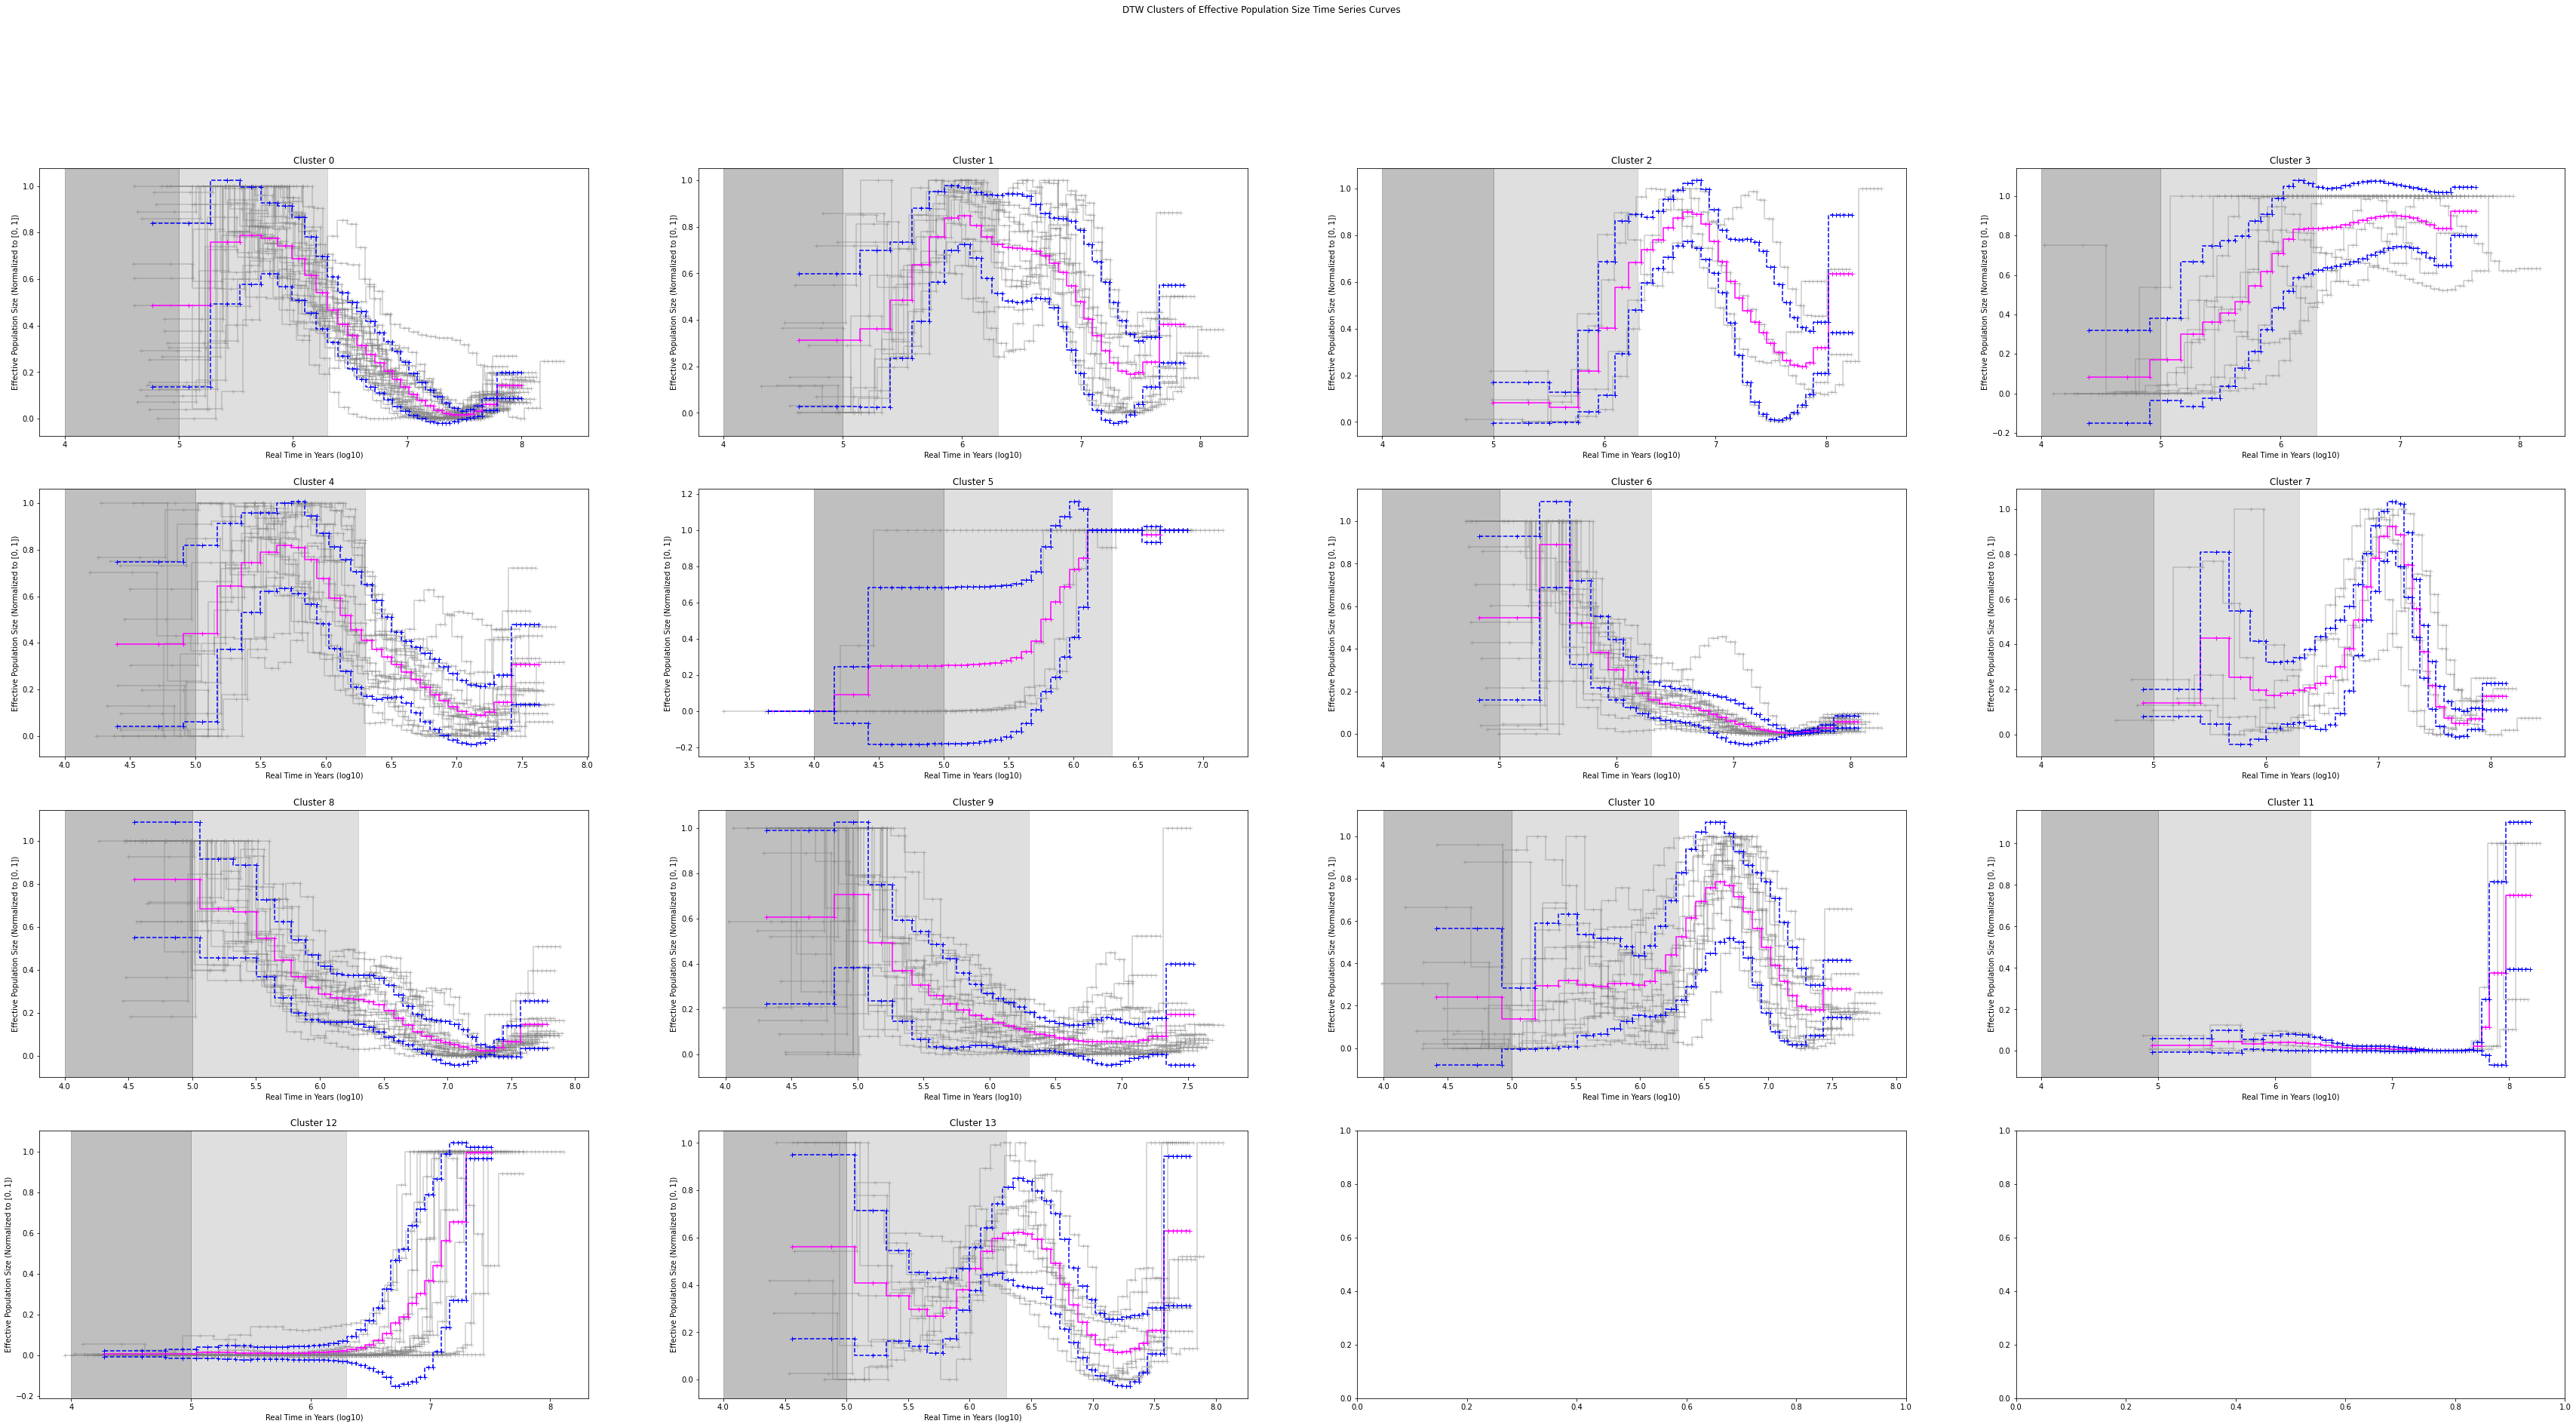

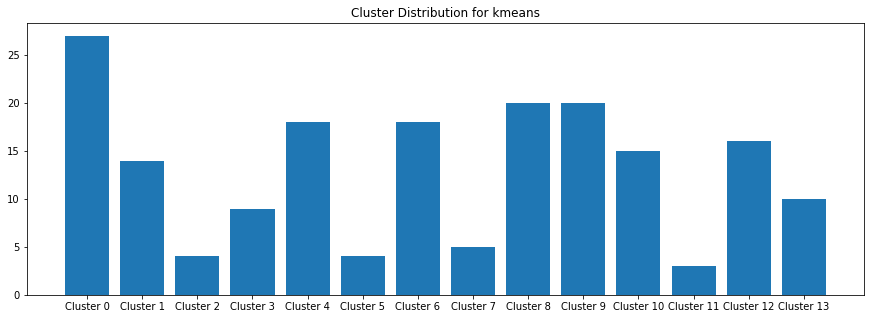

sample len: 183
label len: 183
avg_silhouette_score = 0.2769816016267515


In [ ]:
'''
Best clustering method with more lenient filtering

- Might want to check to see if the samples in heavily skewed curves have some
    sort of historical or geographical barriers
    - Maybe a choropleth scatterplot where samples are dots colored by clusters 
        - Doable with longitude/latitude data
        - Then maybe see if placement of samples on map is Stat sig???
        - Funny thing: Might be able to do an animated time series choropleth 
            using varying pop sizes
'''
figures_path = "MSMC-Exploratory-Analysis/results/figures/"
kshapes_name = "kshapes_clustering.png"

cluster_rt_norm_lenient = Msmc_clustering(directory="msmc_curve_data/", 
                                          mu=1.4e-9, 
                                          generation_time_path='generation_lengths/', 
                                          real_time=True, 
                                          to_omit=omit_test_lenient, 
                                          normalize_lambda=True, 
                                          log_scale_time=True, 
                                          plot_on_log_scale=True, 
                                          exclude_subdirs=["Archive", "mammals_part_1"], 
                                          manual_cluster_count=14,
                                          algo="kmeans") # cluster count by sqrt method is 14

cluster_rt_norm_lenient.cluster_curves(omit_front=0, 
                                       omit_back=0, 
                                       cols=4,  
                                       fs_x=60, 
                                       fs_y=30, 
                                       save_to=figures_path,
                                       metric_params={"gamma" : 1},
                                       save_name="distr_"+kshapes_name)
# Save curve-cluster table
alt_path2 = "MSMC-Exploratory-Analysis/results/lists/"
cluster_rt_norm_lenient.clusterTable.to_csv(alt_path2+"curve-cluster-table.tsv", sep="\t")
# Comment out elbow method part if not needed, it takes forever 
# cluster_rt_norm_lenient.elbow_method()

'''
Silhouette score 
'''
from tslearn.generators import random_walks
from tslearn.metrics import cdist_dtw
from tslearn.clustering import silhouette_score

X = np.array([i.drop("right_time_boundary", axis=1).to_numpy() for i in cluster_rt_norm_lenient.mySeries])
labels = cluster_rt_norm_lenient.dtw_labels
avg_silhouette_score = silhouette_score(X, labels, metric = 'softdtw')
print(f"avg_silhouette_score = {avg_silhouette_score}")

In [ ]:
cluster_rt_norm_lenient.km.cluster_centers_.shape[0]

14

In [ ]:
3//4

0

i: 0, j:  0
i: 0, j:  1
i: 0, j:  2
i: 0, j:  3
i: 1, j:  0
i: 1, j:  1
i: 1, j:  2
i: 1, j:  3
i: 2, j:  0
i: 2, j:  1
i: 2, j:  2
i: 2, j:  3
i: 3, j:  0
i: 3, j:  1


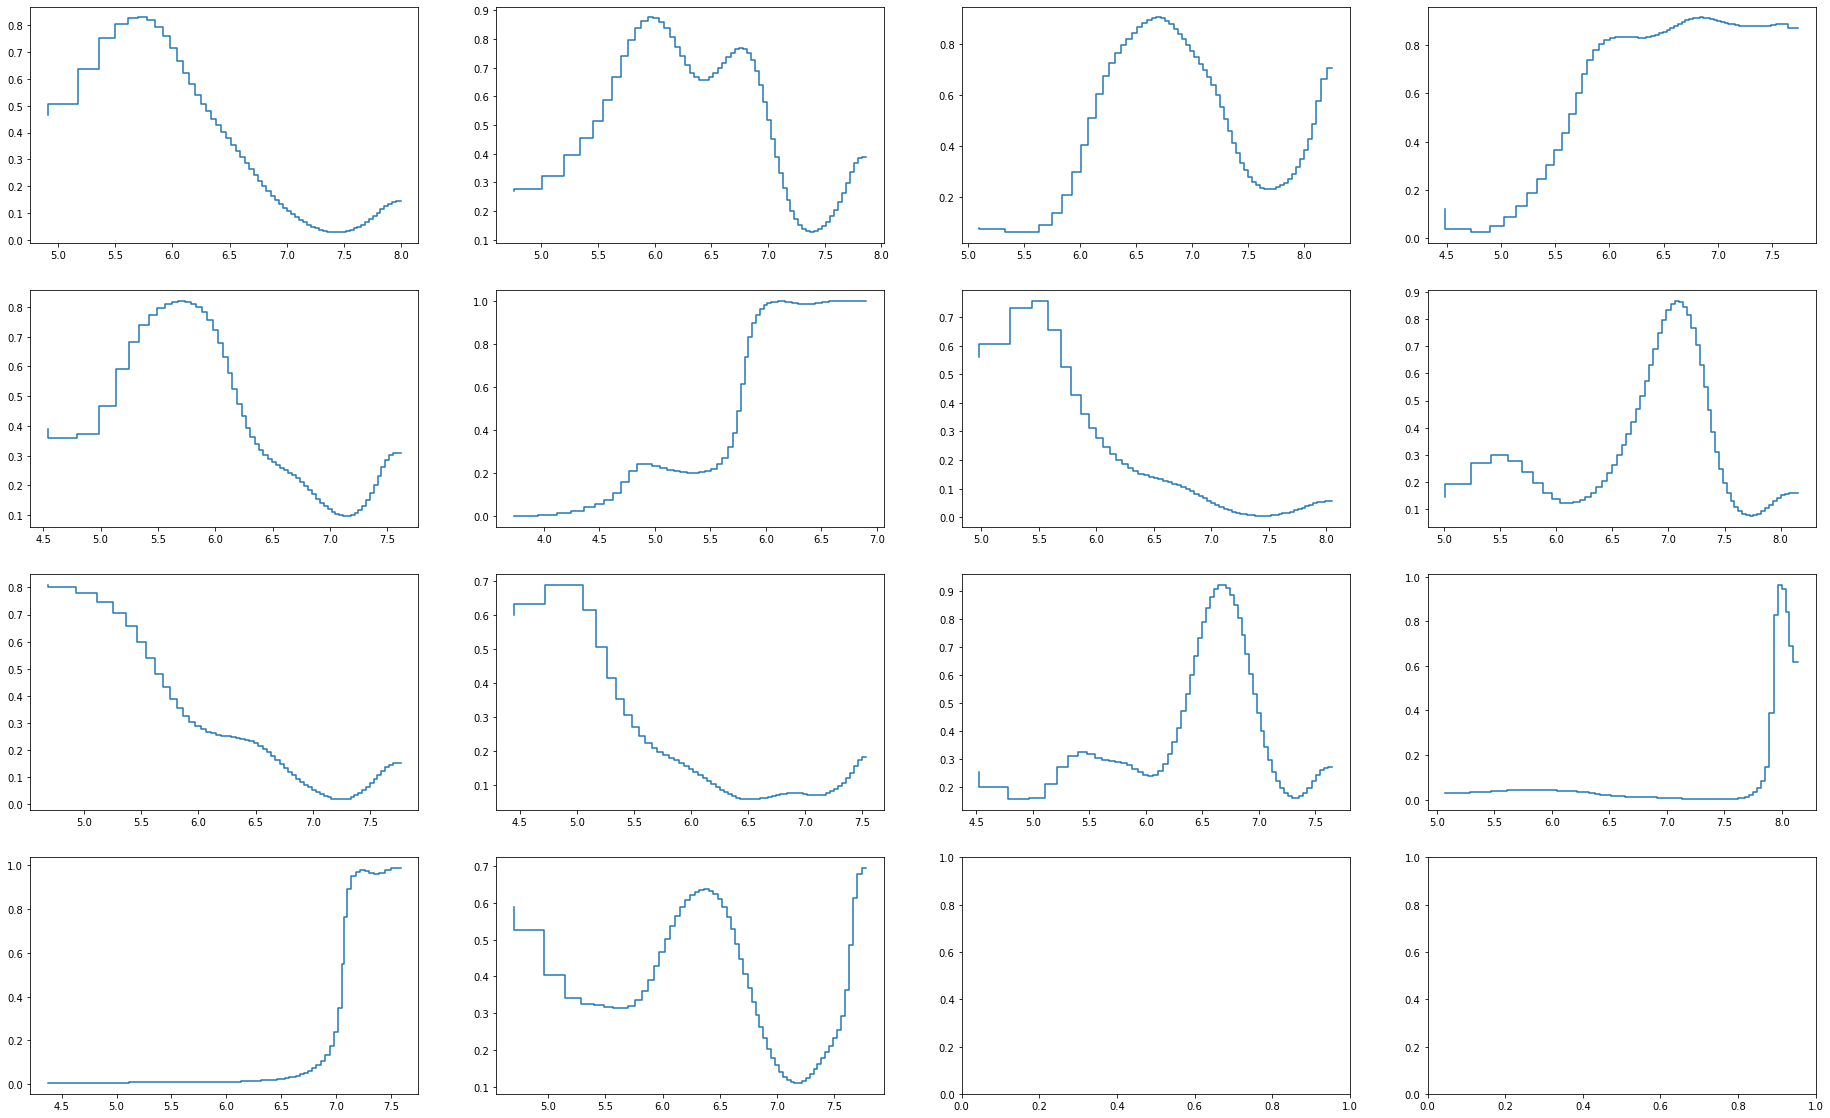

In [ ]:
'''
consider plotting softdtw centroids instead of arithmetic means 
now that softdtw seems to be doing the trick
'''

clusternum = 14 #cluster_rt_norm_lenient.km.cluster_centers_.shape[0]

ncols = 4
nrows = clusternum//ncols + 1 if clusternum > ncols else 1

fig, ax = plt.subplots(nrows, ncols, figsize=(32, 20))

for idx in range(clusternum):
    series = cluster_rt_norm_lenient.km.cluster_centers_[idx]
    x = [i[0] for i in series]
    y = [i[1] for i in series]

    i = idx//ncols 
    j = idx%ncols
    print(f"i: {i}, j:  {j}")
    ax[i][j].step(x, y)

In [ ]:
X = np.array([i.drop("right_time_boundary", axis=1).to_numpy() for i in cluster_rt_norm_lenient.mySeries])
labels = cluster_rt_norm_lenient.dtw_labels
avg_silhouette_score = silhouette_score(X, labels, metric = 'euclidean')
print(f"avg_silhouette_score = {avg_silhouette_score}")

avg_silhouette_score = 0.12627957294158593


# MSMC Clustering on
1.) Normalized Lambda Curves <br>
2.) Unnormalized Lambda Curves

In [3]:
# import stuff for silhouette analysis, REQUIRED for next code block
from tslearn.generators import random_walks
from tslearn.metrics import cdist_dtw, cdist_soft_dtw_normalized
from sklearn.metrics import silhouette_samples as sklearn_silhouette_samples
from sklearn.metrics import silhouette_score as sklearn_silhouette_score
from tslearn.clustering import silhouette_score
from tslearn.utils import to_time_series_dataset, to_time_series
import matplotlib.cm as cm
import json 

def bootleg_silhouette_samples(X, labels, metric=None, sample_size=None,
                     metric_params=None, n_jobs=None, verbose=0,
                     random_state=None, **kwds):
    '''
    Basically the same as how tslearn made silhouette_score i.e. by computing
    a list of pairwise distances I think.
    '''
    sklearn_metric = None
    if metric_params is None:
        metric_params_ = {}
    else:
        metric_params_ = metric_params.copy()
    for k in kwds.keys():
        metric_params_[k] = kwds[k]
    if "n_jobs" in metric_params_.keys():
        del metric_params_["n_jobs"]
    if metric == "precomputed":
        sklearn_X = X
    elif metric == "dtw" or metric is None:
        sklearn_X = cdist_dtw(X, n_jobs=n_jobs, verbose=verbose,
                              **metric_params_)
    elif metric == "softdtw":
        sklearn_X = cdist_soft_dtw_normalized(X, **metric_params_)
    elif metric == "euclidean":
        X_ = to_time_series_dataset(X)
        X_ = X_.reshape((X.shape[0], -1))
        sklearn_X = cdist(X_, X_, metric="euclidean")
    else:
        X_ = to_time_series_dataset(X)
        n, sz, d = X_.shape
        sklearn_X = X_.reshape((n, -1))

        def sklearn_metric(x, y):
            return metric(to_time_series(x.reshape((sz, d)),
                                         remove_nans=True),
                          to_time_series(y.reshape((sz, d)),
                                         remove_nans=True))
    metric = "precomputed" if sklearn_metric is None else sklearn_metric
    return sklearn_silhouette_samples(X=sklearn_X,
                              labels=labels,
                              metric=metric,
                              sample_size=sample_size,
                              random_state=random_state,
                              **kwds)

def plot_sample_silhouette_spectrum(sample_silhouette_values, clusternum:'int', save_to=False, save_name=False):
    y_lower = 10
    for i in range(clusternum): # iterate over current num of clusters 
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / clusternum)
        plt.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")
    # The vertical line for average silhouette score of all the values
    plt.axvline(x=avg_silhouette_score, color="red", linestyle="--")
    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    if save_to:
        plt.savefig(fname=save_to + save_name, dpi = 300)

In [ ]:
'''
Silhouette score clustering scheme test

Description:
Script aids in finding optimal cluster size and gamma to use for clustering based 
on silhouette scores. 

Notes:
Silhouette scores are on the range of [-1, 1] when -1 
is bad and 1 is good. Good silhouette scores reflect high between cluster separation
(high between group sum of squares) and high cluster cohesion (low bwithingn group 
sum of squares). 

Outline of program:
Script below runs clustering based on Soft-DTW with varying Gamma (soft-DTW parameter) 
and Cluster Sizes ( O(G*C) complexity ). Takes a long time to run so be patient.
'''



# path for output
silhouette_path = "MSMC-Exploratory-Analysis/results/silhouette-tests/"
# init a dict keyed by gamma-cluster number combos. Dict to be filled in from nested for loop below
avg_silhouette_score_dict = dict()
# Lists to iterate over
gammas = list(np.arange(0.1, 0.91, 0.2))
clusternums = list(range(2,21))

for gamma in gammas: # Iterate over gammas
    gamma = gamma.round(1) # Round to overcome dumb floating point error with numpy
    curr_gamma_dir = f"gamma_{gamma}" # Set current gamma as a name to be used for output path
    metric_params={"gamma" : gamma} # tslearn soft-dtw  needs gamma param in this format
    # Part 1 of handling directories for output; Specific to gamma
    fig_gamma_path = silhouette_path + "figures/" + curr_gamma_dir # Cluster Fig path
    list_gamma_path = silhouette_path + "lists/" + curr_gamma_dir # Cluster label List/table path
    if curr_gamma_dir not in os.listdir(silhouette_path + "figures/"): # mkdir for figures corresponding to current gamma
        os.mkdir(fig_gamma_path)
    if curr_gamma_dir not in os.listdir(silhouette_path + "lists/"): # mkdir for lists corresponding to current gamma
        os.mkdir(list_gamma_path)
    for clusternum in clusternums:
    # for clusternum in range(2, 10):
        curr_clusternum_dir = f"clusternum_{clusternum}"
        save_name = f"{curr_gamma_dir}_{curr_clusternum_dir}"
        # Part 2 of handling directories for output; Specific to gamma AND clusternum
        fig_path = fig_gamma_path + '/' + curr_clusternum_dir + '/' # Path specific to gamma AND cluster num
        list_path = list_gamma_path  + '/' + curr_clusternum_dir + '/'
        if curr_clusternum_dir not in os.listdir(fig_gamma_path): # mkdir for figures corresponding to current gamma
            os.mkdir(fig_path)
        if curr_clusternum_dir not in os.listdir(list_gamma_path):
            os.mkdir(list_path)

        # print("init")
        cluster_rt_norm_lenient = Msmc_clustering(directory="msmc_curve_data/", 
                                                mu=1.4e-9, 
                                                generation_time_path='generation_lengths/', 
                                                real_time=True, 
                                                to_omit=omit_test_lenient, 
                                                normalize_lambda=True, 
                                                log_scale_time=True, 
                                                plot_on_log_scale=True, 
                                                exclude_subdirs=["Archive", "mammals_part_1"], 
                                                manual_cluster_count=clusternum) # cluster count by sqrt method is 14
        # Perform clustering and save fig
        print("clustering now")
        print("fig_path", fig_path)
        print("save_name", save_name)
        # Below code decides number of rows to achieve a 16:7 picture ratio
        cols = 4
        if clusternum%cols == 0:
            rows = (clusternum//cols)
        else:
            rows = (clusternum//cols) + 1
        fs_x = 64
        fs_y = 7 * rows
        cluster_rt_norm_lenient.cluster_curves(omit_front=0, 
                                            omit_back=0, 
                                            cols=4,  
                                            fs_x=fs_x, 
                                            fs_y=fs_y, 
                                            metric_params=metric_params,
                                            save_to = fig_path,
                                            save_name = save_name+".png")
        
        # Save curve-cluster table
        cluster_rt_norm_lenient.clusterTable.to_csv(list_path + save_name + ".tsv", sep="\t")
        X = np.array([i.drop("right_time_boundary", axis=1).to_numpy() for i in cluster_rt_norm_lenient.mySeries])
        labels = cluster_rt_norm_lenient.dtw_labels
        # Some sort of custom normalization done by tslearn (mod of sklearn silhouette score)
        # which generalizes dimension of X data
        avg_silhouette_score = silhouette_score(X, labels, metric = 'softdtw') 
        sample_silhouette_values = bootleg_silhouette_samples(X, labels, metric = 'softdtw')
        print(f"avg_silhouette_score = {avg_silhouette_score}")
        # Plot sample silhouette spectrum for current clustering
        plot_sample_silhouette_spectrum(sample_silhouette_values, clusternum, save_to=fig_path, save_name=save_name+"_sample_silhouette.png" )
        # Save sample silhoutte spectrum data
        X_names = [i for i in cluster_rt_norm_lenient.namesofMySeries]

        sample_silhouette_csvfile = list_path + save_name + "_sample_silhouette_scores.csv"
        with open(sample_silhouette_csvfile, 'w') as mf:
            for idx in range(len(X_names)):
                mf.write(f"{X_names[idx]},{labels[idx]},{sample_silhouette_values[idx]}\n")

        key = f"g{gamma} c{clusternum}"
        avg_silhouette_score_dict[key] = avg_silhouette_score
# Save avg_silhouette_score_dict as csv
import csv
csvfile = "avg_silhouette_scores.csv"
# csvfile = "avg_silhouette_scores.csv"
with open(silhouette_path + csvfile, 'w') as f:
    for key in avg_silhouette_score_dict.keys():
        f.write(f"{key},{avg_silhouette_score_dict[key]}\n")

In [ ]:
# '''
# Kshapes clustering test
# '''

# kshapes_path = "MSMC-Exploratory-Analysis/results/KShapes-tests/"
# algo = "kshapes"
# # clusternums = list(range(2,21))
# clusternums = [13]
# # Part 1 of handling directories for output
# fig_path = kshapes_path + "figures/" # Cluster Fig path
# list_path = kshapes_path + "lists/" # Cluster label List/table path

# for clusternum in clusternums:
# # for clusternum in range(2, 10):
#     curr_clusternum_dir = f"clusternum_{clusternum}"
#     save_name = f"{algo}_{curr_clusternum_dir}"

#     cluster_rt_norm_lenient = Msmc_clustering(directory="msmc_curve_data/", 
#                                             mu=1.4e-9, 
#                                             generation_time_path='generation_lengths/', 
#                                             real_time=True, 
#                                             to_omit=omit_test_lenient, 
#                                             normalize_lambda=True, 
#                                             log_scale_time=True, 
#                                             plot_on_log_scale=True, 
#                                             exclude_subdirs=["Archive", "mammals_part_1"], 
#                                             manual_cluster_count=clusternum,
#                                             algo=algo) # cluster count by sqrt method is 14
#     # Perform clustering and save fig
#     print("clustering now")
#     print("fig_path", fig_path)
#     print("save_name", save_name)
#     # Below code decides number of rows to achieve a 16:7 picture ratio
#     cols = 4
#     if clusternum%cols == 0:
#         rows = (clusternum//cols)
#     else:
#         rows = (clusternum//cols) + 1
#     fs_x = 64
#     fs_y = 7 * rows
#     cluster_rt_norm_lenient.cluster_curves(omit_front=0, 
#                                         omit_back=0, 
#                                         cols=4,  
#                                         fs_x=fs_x, 
#                                         fs_y=fs_y, 
#                                         save_to = fig_path,
#                                         save_name = save_name+".png")
    
#     # Save curve-cluster table
#     cluster_rt_norm_lenient.clusterTable.to_csv(list_path + save_name + ".csv")

Text(0.5, 1.0, 'Silhoutte Scores over Cluster Number and Gamma')

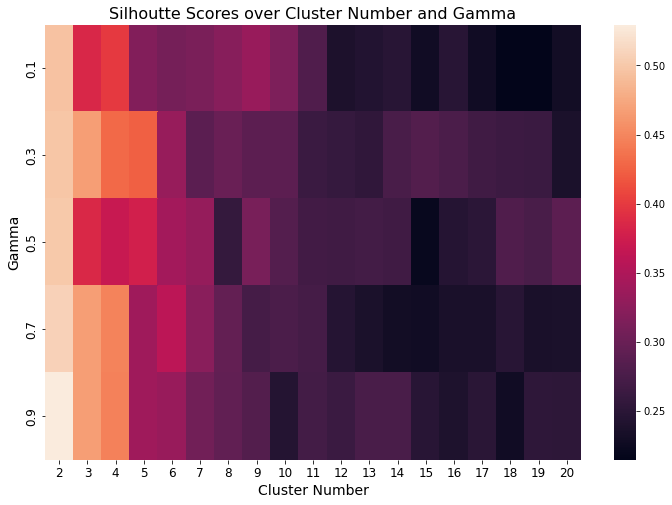

In [4]:
'''
Script generates heatmap for silhouette scores for clustering settings

might want to run clustering on sizes 2-9 with gamma 0.1-0.9 in steps of 0.2
for fuller picture of silhouette landscape
'''
# Read clustering data (Silhouette scores)
silhouette_path = "MSMC-Exploratory-Analysis/results/silhouette-tests/"
csvfile = "avg_silhouette_scores.csv"
with open(silhouette_path + csvfile, 'r') as myfile:
    df_dict = dict()
    df_cols = set()
    for line in myfile:
        key_str, val_str = line.split(",")
        X_idx_g, Y_idx_c = key_str.split(" ")
        gamma = float(X_idx_g[1:])
        clustnum = int(Y_idx_c[1:])
        if gamma not in df_dict:
            df_dict[gamma] = []
        df_dict[gamma].append(float(val_str))
        df_cols.add(clustnum)
# Create pandas df for sns heatmap input
df = pd.DataFrame(df_dict.values(),columns=df_cols,index=df_dict.keys()).sort_index() 
# Create heatmap
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(df)
plt.tick_params(axis='both',labelsize=12)
ax.set_xlabel("Cluster Number", fontsize=14)
ax.set_ylabel("Gamma", fontsize=14)
ax.set_title("Silhoutte Scores over Cluster Number and Gamma", fontsize=16)

In [17]:
'''
Find the clustering scheme (combo of gamma and cluster num) that minimizes
diff btwn AVG cluster silhouette score and Total AVG silhouette score.

Output can be like an ordered df or list
'''

# (1.) Read in data for AVG Silhouette scores as a df
silhouette_path = "MSMC-Exploratory-Analysis/results/silhouette-tests/"
csvfile = "avg_silhouette_scores.csv"
with open(silhouette_path + csvfile, 'r') as myfile:
    df_dict = dict()
    df_cols = set()
    for line in myfile:
        key_str, val_str = line.split(",")
        X_idx_g, Y_idx_c = key_str.split(" ")
        gamma = float(X_idx_g[1:])
        clustnum = int(Y_idx_c[1:])
        if gamma not in df_dict:
            df_dict[gamma] = []
        df_dict[gamma].append(float(val_str))
        df_cols.add(clustnum)
df_AVG_silhouettes = pd.DataFrame(df_dict.values(),columns=df_cols,index=df_dict.keys()).sort_index() # Cluster num X Gamma
# Pandas df for AVG silhouette scores over Gamma and Clusternum
# df follows the scheme (gammas, clusternums)

# (2.) Read in data for cluster AVG Silhouette scores
dict_df_sample_silhouette_clustAVGs = dict() # Keys follow the scheme "g{gamma} c{clusternum}", dict containing all recorded silhouette cluster AVGs for each clustering scheme (gamma, clusternum)
dict_df_sample_silhouette_scores = dict() # dict containing all recorded silhouette score dfs for each clustering scheme (gamma, clusternum)
silhouette_list_path = silhouette_path + "lists/"
gamma_dirs = os.listdir(silhouette_list_path) # List of gamma dirs
for gamma_dir in gamma_dirs: # gamma_dir is name of curr gamma dir
    gamma = float(gamma_dir.split("_")[1]) # Curr value of gamma
    gamma = np.around(gamma, 1) # Do this just in case to avoid floating point error
    clusternum_dirs = os.listdir(silhouette_list_path + gamma_dir) # List of clusternum dirs
    # clusternum_dirs = clusternum_dirs.sort()
    for clusternum_dir in clusternum_dirs: # clusternum_dir is name of curr clusternum dir
        clusternum = int(clusternum_dir.split("_")[1]) # Curr clusternum
        # print(f"gamma: {gamma} and clusternum: {clusternum}")
        sample_silhouette_scores_path = silhouette_list_path + gamma_dir + "/" + clusternum_dir + "/"
        silhouette_fname = f"{gamma_dir}_{clusternum_dir}_sample_silhouette_scores.csv"
        # print(sample_silhouette_scores_path + silhouette_fname)
        df_sample_silhouette = pd.read_csv(sample_silhouette_scores_path + silhouette_fname)
        col_names = ["Sample", "Labels", "Sample_silhouette_score"]
        df_sample_silhouette.columns = col_names
        df_sample_silhouette = df_sample_silhouette.drop(["Sample"], axis=1)
        df_sample_silhouette_clustAVGs = df_sample_silhouette.groupby(["Labels"]).mean()
        dict_df_sample_silhouette_clustAVGs[f"g{gamma} c{clusternum}"] = df_sample_silhouette_clustAVGs
        dict_df_sample_silhouette_scores[f"g{gamma} c{clusternum}"] = df_sample_silhouette #.sort_values("Labels") # Sorting not absolutely necessary



# (3.) Selecting optimal cluster size based on silhouette statistics
# [NEW PLAN] Might just have to check to see the REL FREQS of clusters who's mean silhouette scores pass the AVG silhouette score threshold. 
# Then pick the clustering scheme with the most well placed clusters
# See: https://towardsdatascience.com/silhouette-method-better-than-elbow-method-to-find-optimal-clusters-378d62ff6891
# [OG PLAN] Compute sum of squared mean errors between each clustering and their AVG silhouette score
# Might redo this, only compute dists of means that fall below AVG
# Check to see that we aren't reinventing the wheel

clusternums = list(df_AVG_silhouettes.columns)
gammas = list(df_AVG_silhouettes.index)
# (dict_df_sample_silhouette_clustAVGs["g0.9 c10"] - df_AVG_silhouettes[10].loc[0.9] > 0).sum()
df_clusterscheme_goodcluster_counts_aboveAVG = pd.DataFrame(columns = clusternums, index=gammas)
df_clusterscheme_goodcluster_counts_hasAboveAVG = pd.DataFrame(columns = clusternums, index=gammas)
for gamma in gammas:
    for clusternum in clusternums:
        df_clusterscheme_goodcluster_counts_aboveAVG[clusternum].loc[gamma] = float((dict_df_sample_silhouette_clustAVGs[f"g{gamma} c{clusternum}"] - df_AVG_silhouettes[clusternum].loc[gamma] > 0).sum())
        df_clusterscheme_goodcluster_counts_hasAboveAVG[clusternum].loc[gamma] = 

In [23]:
df_AVG_silhouettes[6].loc[0.9]

0.33430500007228436

In [29]:
dict_df_sample_silhouette_scores["g0.9 c6"]

,Labels,Sample_silhouette_score
0,0,0.429286
1,3,0.210768
2,0,0.472679
3,4,0.456264
4,3,0.172393
...,...,...
177,3,0.292320
178,5,0.000112
179,1,-0.061486
180,5,0.542178


In [20]:
df_clusterscheme_goodcluster_counts_hasAboveAVG

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
# Compare
# Group by
# Count
dict_df_sample_silhouette_scores["g0.9 c6"] > df_AVG_silhouettes[6].loc[0.9].groupby("Labels") 

AttributeError: ignored

In [7]:
clusternums = list(df_AVG_silhouettes.columns)
gammas = list(df_AVG_silhouettes.index)
df_clusterscheme_goodcluster_counts = pd.DataFrame(columns = clusternums, index=gammas)
for gamma in gammas:
    for clusternum in clusternums:
        # val = np.around(int((dict_df_sample_silhouette_clustAVGs[f"g{gamma} c{clusternum}"] - df_AVG_silhouettes[clusternum].loc[gamma] > 0).sum()) / clusternum, 2)
        val = int((dict_df_sample_silhouette_clustAVGs[f"g{gamma} c{clusternum}"] - df_AVG_silhouettes[clusternum].loc[gamma] > 0).sum())
        df_clusterscheme_goodcluster_counts[clusternum].loc[gamma] = val
df_clusterscheme_goodcluster_counts
# Create heatmap
# fig, ax = plt.subplots(figsize=(12, 8))
# sns.heatmap(df_clusterscheme_goodcluster_counts)

# plt.tick_params(axis='both',labelsize=12)
# ax.set_xlabel("Cluster Number", fontsize=14)
# ax.set_ylabel("Gamma", fontsize=14)
# ax.set_title("Silhoutte Scores over Cluster Number and Gamma", fontsize=16)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0.1,1,1,2,2,3,4,4,4,4,5,6,7,8,8,10,10,10,10,10
0.3,1,2,2,3,3,4,4,5,6,4,6,4,5,5,6,6,8,7,8
0.5,1,1,1,2,3,4,4,4,3,5,4,6,5,8,6,7,8,8,7
0.7,1,2,2,3,2,3,3,2,5,6,5,6,6,7,7,8,9,9,10
0.9,1,2,2,3,3,3,3,5,5,5,4,5,6,6,7,8,8,8,10


In [ ]:
# '''
# Elbow method curve illustrates distribution of "average variation" (inertia) over 
# runs of clustering (varying number of clusters). Might help in brute forcing the
# task of finding the best number of clusters to use

# If plot not in notebook, check out directory for plot png
# '''

# if "elbow-method-plot.png" not in os.listdir(figures_path):
#     cluster_rt_norm_lenient.elbow_method(save_to=figures_path)

In [ ]:
# Save curve-cluster table
alt_path2 = "MSMC-Exploratory-Analysis/results/lists/"
cluster_rt_norm_lenient.clusterTable.to_csv(alt_path2+"curve-cluster-table.tsv", sep="\t")

# Meta data analysis

In [ ]:
# for name in cluster_rt_norm_lenient.namesofMySeries:
#     cluster_rt_norm_lenient.plot_curve(name)

In [ ]:
'''
Bioproject https://www.ncbi.nlm.nih.gov/bioproject/545868 has more info kind of.
Really just has associated assembly accession (GCA)

Gonna have to work on this data like a Relational Database

Todo:
- Display following distr in cluster:
    - Order
    - Family
    - Contig N50
    - Scaffold
'''

In [ ]:
'''
Make a class to help read in metadata as dataframes
'''

class MetaDataVis():
    '''
    Use to help make data vis more convenient. By default read in all columns (handled
    by the labels arg)
    '''
    def __init__(self, metaDataPath: "str", labels: "list<str>" = None):
        self.metaDataPath = metaDataPath
        self.labels = labels # Stores a list of features to include from meta data file
        self.df_meta = self.makeDF()

    def makeDF(self):
        df_meta = pd.read_excel(self.metaDataPath, header = 1)
        if self.labels:
            drop_labels = (key for key in df_meta.keys() if key not in self.labels)
            df_meta = df_meta.drop(labels=drop_labels, axis=1) # Drop unnecessary columns
        df_meta["Latin name"] = pd.Series([name.replace(" ", "_") for name in df_meta["Latin name"]]) # Make Latin names col more appropriate
        df_meta = df_meta.sort_values("Latin name")
        df_meta = df_meta.set_index("Latin name") # Set Latin name as identifier column
        return df_meta

meta_data_path = "msmc_meta_data/Supplementary_Table_1_corrected.xlsx"

labels = ["Latin name", "Order", "Family", "Contig_N50 (bp)", "Scaffold_N50 (bp)", "Site",	
          "State/Province", "County/District", "Country", "Latitude", "Longitude", "Coordinate notes",
          'Contig_L50 (bp)', 'Contig_Num', 'Scaffold_L50 (bp)', 'Scaffold_Num (bp)', 'Total_Len (bp)', 'Gap_Len (bp)', 
          'Gap_Ratio (%)', 'Complete BUSCOs (C, %)', 'Complete and single-copy BUSCOs (S, %)', 
          'Complete and duplicated BUSCOs (D, %)', 'Fragmented BUSCOs (F, %)', 'Missing BUSCOs (M, %)', 
          'CG content(%)', 'Depth', 'Genome Accession']

qc_labels = ["Latin name", "Contig_N50 (bp)",	"Contig_L50 (bp)",	"Contig_Num",	"Scaffold_N50 (bp)",	
"Scaffold_L50 (bp)", "Scaffold_Num (bp)",	"Total_Len (bp)",	"Gap_Len (bp)",	
"Gap_Ratio (%)",	"Complete BUSCOs (C, %)",	"Complete and single-copy BUSCOs (S, %)",	
"Complete and duplicated BUSCOs (D, %)",	"Fragmented BUSCOs (F, %)",	
"Missing BUSCOs (M, %)", "CG content(%)",	"Depth"] # List of mainly asm QC stats

df_meta = MetaDataVis(metaDataPath=meta_data_path)
df_qc = MetaDataVis(metaDataPath=meta_data_path, labels=qc_labels)

In [ ]:
'''
Pairplot settings
'''
pd.set_option('display.max_columns', None)


plot_pairplots = True


b100k_names_list = [name for name in cluster_rt.latin_names if name in df_meta.df_meta.index] # Make list of names which are contained in metadata xlsx (B100K entries)
df_meta_lenient = df_meta.df_meta.loc[b100k_names_list]
df_qc_lenient = df_qc.df_meta.loc[b100k_names_list]

# Add additional feature to df_qc_lenient to specify which entries were omitted or not
df_meta_lenient["used_data"] = [True if latin_id in kept_test_lenient_latin else False for latin_id in df_qc_lenient.index]
df_qc_lenient["used_data"] = [True if latin_id in kept_test_lenient_latin else False for latin_id in df_qc_lenient.index]

# Path to save pairplots/qc figures
lenient_filter_figures_path = "MSMC-Exploratory-Analysis/results/figures/msmc_meta_data"



In [ ]:
df_meta_lenient

In [ ]:
'''
No visible association between presence of Longitude/Latitude info and used_data.

Want to check if:
- Species habitat (longitude/latitude info) 
- Source institution (where sequencing likely happened)
- Elevation (masl) [masl = meters above sea level
- Date collected
are associated with bad data.

'''
df_meta_lenient[["Source institution", "Longitude", "Latitude", "Elevation (masl) [masl = meters above sea level]", "Date collected", "used_data"]].info()
print()
# Plotting Source institude data
df_source = df_meta_lenient[["Source institution", "used_data"]].dropna()
plt.figure(figsize = (15,8))
plt.title("Source institude used data distr")
ax_countplot = sns.countplot(x="Source institution", data = df_source, hue = "used_data")
ax_countplot.set_xticklabels(ax_countplot.get_xticklabels(), rotation=90)
print()
# Plotting longitude data
df_meta_lonlat = df_meta_lenient[["Longitude", "Latitude", "used_data"]].dropna()
print()
# Plotting elevation data
df_elevation = df_meta_lenient[["Elevation (masl) [masl = meters above sea level]", "used_data"]].dropna()
elevations = []
for record in df_elevation["Elevation (masl) [masl = meters above sea level]"].to_numpy():
    if "-" in record:
        record = [int(i) for i in record.split("-")]
        record = sum(record)/len(record)
    elevations.append(int(record))
df_elevation["Elevation (masl)"] = elevations
plt.figure(figsize = (15,8))
plt.title("Elevation distr of used data")
ax_swarmplot_elevation = sns.swarmplot(x="used_data", y="Elevation (masl)", data = df_elevation, hue = "used_data")
ax_swarmplot_elevation.set_xticklabels(ax_swarmplot_elevation.get_xticklabels(), rotation=90)
print()
# Plotting date data
df_date = df_meta_lenient[["Date collected", "used_data"]].dropna()
days = []
months = []
years = []

for date in df_date["Date collected"].tolist(): # Pretty lazy analysis of time idc
    try:
        dt = datetime.datetime.strptime(date, '%d-%b-%y')
        days.append(dt.day)
        months.append(dt.month)
        years.append(dt.year)
    except: 
        days.append(np.nan)
        months.append(np.nan)
        years.append(np.nan)      
        pass

df_date["days"] = days
df_date["months"] = months
df_date["years"] = years
df_date

plt.figure(figsize = (15,8))
plt.title("Years of used data distr")
ax_countplot_years = sns.countplot(x="years", data = df_date, hue = "used_data")
ax_countplot_years.set_xticklabels(ax_countplot_years.get_xticklabels(), rotation=90)

plt.figure(figsize = (15,8))
plt.title("Months of used data distr")
ax_countplot_years = sns.countplot(x="months", data = df_date, hue = "used_data")
ax_countplot_years.set_xticklabels(ax_countplot_years.get_xticklabels(), rotation=90)

plt.figure(figsize = (15,8))
plt.title("Days of used data distr")
ax_countplot_years = sns.countplot(x="days", data = df_date, hue = "used_data")
ax_countplot_years.set_xticklabels(ax_countplot_years.get_xticklabels(), rotation=90)
print()

In [ ]:
# Plotting longitude data
df_meta_lonlat = df_meta_lenient[["Longitude", "Latitude", "used_data"]].dropna()
df_meta_lonlat

In [ ]:
countries = gpd.read_file(
               gpd.datasets.get_path("naturalearth_lowres"))
countries.head()
countries.plot(color="lightgrey")


In [ ]:
lon_pairs = [i.split(" ")  for i in df_meta_lonlat.Longitude.tolist()]
for pair in lon_pairs:
    float(pair[0])

In [ ]:
df_meta_lonlat

In [ ]:
def lonlat_str2float(longitude : list<str> = None, latitude : list<str> = None) -> tuple<list<float>, list<float>>:
    '''
    Converts lists of longitude or latitude coords from strings to floats. 
    Hardcoded to how metadata for B100K data was received
    '''

In [ ]:
type(df_meta_lonlat["Longitude"].loc[ "Bucco_capensis"])

In [ ]:
'''
Perform pairplots

If pairplots aren't in notebook, they are probably saved in their respective 
directories
'''

plot_pairplots = False

# Pairplot for 1st half of metadata
if "pairplot_1st_half_fig.png" not in os.listdir(lenient_filter_figures_path) or plot_pairplots: # Run pairplot code if plot isn't already found
    pairplot_1st_half = sns.pairplot(df_qc_lenient, hue = "used_data",
                vars = ["used_data", "Contig_N50 (bp)",	"Contig_L50 (bp)",	"Contig_Num",	"Scaffold_N50 (bp)",	
                "Scaffold_L50 (bp)", "Scaffold_Num (bp)",	"Total_Len (bp)",	"Gap_Len (bp)",	
                "Gap_Ratio (%)"], height = 5)
    pairplot_1st_half_fig_name = "pairplot_1st_half_fig.png"
    pairplot_1st_half.savefig(lenient_filter_figures_path + pairplot_1st_half_fig_name, dpi=300)


# Pairplot for 2nd half of metadata
if "pairplot_2nd_half_fig.png" not in os.listdir(lenient_filter_figures_path) or plot_pairplots: # Run pairplot code if plot isn't already found
    pairplot_2nd_half = sns.pairplot(df_qc_lenient, hue = "used_data",
                vars = ["used_data", "Complete BUSCOs (C, %)",	"Complete and single-copy BUSCOs (S, %)",	
                "Complete and duplicated BUSCOs (D, %)",	"Fragmented BUSCOs (F, %)",	
                "Missing BUSCOs (M, %)", "CG content(%)",	"Depth"], height = 5)
    pairplot_2nd_half_fig_name = "pairplot_2nd_half_fig.png"
    pairplot_2nd_half.savefig(lenient_filter_figures_path + pairplot_2nd_half_fig_name, dpi=300)

# Pairplot for 1st half of metadata
if "pairplot_fig.png" not in os.listdir(lenient_filter_figures_path) or plot_pairplots: # Run pairplot code if plot isn't already found
    pairplot = sns.pairplot(df_qc_lenient, hue = "used_data",
                vars = df_qc_lenient.columns.tolist(), height = 5 )
    pairplotfig_name = "pairplot_fig.png"
    pairplot.savefig(lenient_filter_figures_path + pairplotfig_name, dpi=300)


In [ ]:
df_meta.df_meta.columns[41:55].tolist()

In [ ]:
'''
Repeat annotation pairplot
'''

more_md_cols = df_meta.df_meta.columns[41:55].tolist()
# Pairplot for metadata including repeat annotations
if "pairplot_repeat_ann_fig.png" not in os.listdir(lenient_filter_figures_path) or plot_pairplots: # Run pairplot code if plot isn't already found
    pairplot = sns.pairplot(df_meta_lenient, hue = "used_data",
                vars = more_md_cols, height = 5 )
    pairplotfig_name = "pairppairplot_repeat_ann_figlot_fig.png"
    pairplot.savefig(lenient_filter_figures_path + pairplotfig_name, dpi=300)

In [ ]:
asm_ann = df_meta_lenient.columns.tolist()[24:31] + df_meta_lenient.columns.tolist()[48:55] 

In [ ]:
'''
EVERYTHING pairplot
crashes
'''

more_md_cols = asm_ann
# Pairplot for metadata including repeat annotations
if "pairplot_meta_data_and_repeat_ann_fig.png" not in os.listdir(lenient_filter_figures_path) or plot_pairplots: # Run pairplot code if plot isn't already found
    pairplot = sns.pairplot(df_meta_lenient, hue = "used_data",
                vars = more_md_cols, height = 5 )
    pairplotfig_name = "pairplot_meta_data_and_repeat_ann_fig.png"
    pairplot.savefig(lenient_filter_figures_path + pairplotfig_name, dpi=300)

In [ ]:
'''
Perform 2D PCA on metadata to see if the omitted files fall into any clusters
'''

sklearn_pca = PCA(n_components=2)
features_list = df_qc_lenient.columns[:-1]
sklearn_pca.fit(df_qc_lenient[features_list]) # Fit a PCA on all qc metadata
print('Variance percent explained\n', sklearn_pca.explained_variance_ratio_)


df_2D = pd.DataFrame(sklearn_pca.transform(df_qc_lenient[features_list]),
                     columns=['PCA1', 'PCA2'])
df_2D['used_data'] = df_qc_lenient['used_data'].tolist()

for key, group in df_2D.groupby(['used_data']):
    plt.plot(group.PCA1, group.PCA2, 'o', alpha=0.7, label=key)

# Tidy up plot
plt.legend(loc=0, fontsize=15)
plt.margins(0.05)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title("2D PCA on B100K metadata")
plt.savefig(lenient_filter_figures_path+"2D_PCA.png")

In [ ]:
'''
Perform 3D PCA on metadata to see if the omitted files fall into any clusters
'''

sklearn_pca = PCA(n_components=3)
features_list = df_qc_lenient.columns[:-1]
sklearn_pca.fit(df_qc_lenient[features_list]) # Fit a PCA on all qc metadata
print('Variance percent explained\n', sklearn_pca.explained_variance_ratio_)


# Store results of PCA in a data frame
result=pd.DataFrame(sklearn_pca.transform(df_qc_lenient[features_list]), columns=['PCA%i' % i for i in range(3)], index=df_qc_lenient.index)
 
# Plot initialisation
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(result['PCA0'], result['PCA1'], result['PCA2'], c=df_qc_lenient["used_data"], cmap="Set2_r", s=60)

# make simple, bare axis lines through space:
xAxisLine = ((min(result['PCA0']), max(result['PCA0'])), (0, 0), (0,0))
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
yAxisLine = ((0, 0), (min(result['PCA1']), max(result['PCA1'])), (0,0))
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
zAxisLine = ((0, 0), (0,0), (min(result['PCA2']), max(result['PCA2'])))
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')
 
# label the axes
ax.legend(loc=0, fontsize=15)
ax.margins(0.05)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("3D PCA on B100K metadata")
plt.savefig(lenient_filter_figures_path+"3D_PCA.png")

In [ ]:
df_qc_lenient

In [ ]:
ax_boxplot = sns.boxplot(x="used_data", y="Contig_N50 (bp)", data = df_qc_lenient, hue = "used_data")
ax_boxplot.set_title("Contig N50 (bps) distr of used/unused B100K data")

In [ ]:
ax_swarmplot = sns.swarmplot(x="used_data", y="Contig_N50 (bp)", data = df_qc_lenient, hue = "used_data")
ax_swarmplot.set_title("Contig N50 (bps) distr of used/unused B100K data")

In [ ]:
ax_boxplot = sns.boxplot(x="used_data", y="Scaffold_N50 (bp)", data = df_qc_lenient, hue = "used_data")


In [ ]:
ax_boxplot = sns.boxplot(x="used_data", y="Complete BUSCOs (C, %)", data = df_qc_lenient, hue = "used_data")

In [ ]:
ax_boxplot = sns.boxplot(x="used_data", y="Fragmented BUSCOs (F, %)", data = df_qc_lenient, hue = "used_data")

In [ ]:
from IPython.core.pylabtools import figsize
'''
With a cluster, print out plots of quality info distr and stuff

Maybe plot using comprehensive list of metrics

Actually a lot of stuff (relationships, correlation, covariances) to think about
now with all dis meta data 

Might need to include a list of all Families since some Families only have 1 rep which
can be filtered out, making bargraphs for Fam and Order uneven
'''

def cluster_metric_distr(clusters: "list[Msmc_clustering]",  meta_data_df: "df", metrics_list:"list[str]", label: "int/None" = None, logscale=False, family_list=None):
    '''
    Compares metrics of different clusters

    family_list: Superset of all possible families to consider for related barcharts
    '''
    if label == None:
        label_clusters = dict() # dict[df]
        keys = []
        for idx, cluster in enumerate(clusters):
            label_clusters[f"cluster{idx}"] = cluster.clusterTable
            keys.append(f"cluster{idx}")
    else:
        label_clusters = dict() # dict[df]
        keys = []
        for idx, cluster in enumerate(clusters):
            label_clusters[f"cluster{idx}"] = cluster.cluster_from_label(label)
            keys.append(f"cluster{idx}")
    rows = len(keys) # Rows should correspond to number of clusters
    cols = len(metrics_list) # Cols should correspond to number of metrics
    fig, axs = plt.subplots(nrows = rows , ncols = cols, figsize=(60,15))
    for i, key in enumerate(keys): # Iterate over clusters
        cluster_sample_indices = label_clusters[key].index # Retrieve Latin name indices of samples
        cluster_meta = meta_data_df.df_meta.loc[cluster_sample_indices] # Retrieve df of meta data pertaining to samples
        for j, metrics in enumerate(metrics_list): # Iterate over metrics
            samples_by_metric = cluster_meta[metrics] # Whatever list/column from metadata file that corresponds to desired metric
            indexer = [i,j] if rows > 1 else [j]
            if isinstance(samples_by_metric[0], str): # If metric contains categorical data
                
                if family_list and metrics=="Family": # Fill in tota
                    metric = family_list
                    performance = [samples_by_metric.tolist().count(order) for order in family_list]  
                else:
                    metric = samples_by_metric.unique()
                    performance = [samples_by_metric.tolist().count(order) for order in metric]
                y_pos = np.arange(len(performance))
                # print(metric.tolist())
                # print(performance)
                axs[i, j].bar(y_pos, performance, tick_label=metric,  align='center', alpha=0.5)
                axs[i, j].set_xticklabels(metric, rotation=90)
                axs[i, j].set_ylabel('Count')
                axs[i, j].set_title(f'{metrics} distribution in Cluster {label}')
            else: # If metric contains quantitative data
                '''
                A lot of potential crap to plot:
                - Distr of quantitative stuff just within current cluster (Start here with some simple histograms covering within-cluster data)
                - Distr of quantitative stuff in categories within cluster
                - Distr of stuff inside of stuff inside of current cluster???

                Maybe just start by making histograms
                '''
                if logscale:
                    data = np.log10(samples_by_metric)
                else:
                    data = samples_by_metric
                axs[i, j].hist(data)
                axs[i, j].set_xlabel(metrics)
                axs[i, j].set_ylabel('Count')
                axs[i, j].set_title(f'{metrics} distribution in {key}, label {label}\nMean: {np.mean(data)}\nVariance: {np.var(data)}')
    fig.tight_layout()
    plt.show()
        

In [ ]:
family_list = list(set(df_meta.df_meta["Family"].unique()))
order_metrics = ["Order", "Family"]
asm_metrics = ["Contig_N50 (bp)", "Contig_Num", "Scaffold_N50 (bp)", "Scaffold_Num (bp)"]
gap_metrics = ["Gap_Len (bp)", "Gap_Ratio (%)"]
busco_metrics = ["Complete BUSCOs (C, %)", "Complete and single-copy BUSCOs (S, %)", "Complete and duplicated BUSCOs (D, %)",
                 "Fragmented BUSCOs (F, %)", "Missing BUSCOs (M, %)"]

In [ ]:
'''
It looks like the majority of removed files belonged to Passeriformes. Kinda 
makes sense since Passeriformes comprise the majority of the dataset
'''

cluster_metric_distr(clusters=[cluster_rt, cluster_rt_norm_lenient], meta_data_df=df_meta, metrics_list=order_metrics, label=None, family_list=family_list)

In [ ]:
def plot_feature_comparison(metadata_df, outgroup_index_list, feature):
    '''
    Compares a feature from entries in outgroup to thoes from the rest in 
    in metadata_df.

    '''

In [ ]:
'''
Confirms that the majority of files filtered out were Passeriformes.
'''
plt.figure(figsize=(10,5))

omit_test_latin = [name[:name.index("_GCA")] for name in omit_test_lenient]
df_omit = df_meta.df_meta.loc[omit_test_latin] # Data frame of B100K metadata on "elbow" curves

def plot_feature_distribution(metadata_df, feature):
    '''
    Use this plotting function to isolate where the elbow curves stick out from
    normal looking curves in terms of metadata stats

    2 boxplots for kept and omitted features measuring metrics of quality like N50
    '''
    feature_data = df_omit[feature].tolist()
    feature_data_X = list(set(feature_data)) # X
    y_pos = np.arange(len(feature_data_X))
    feature_data_Y =[feature_data.count(x) for x in feature_data_X]  # Y
    plt.bar(y_pos, feature_data_Y)
    plt.xticks(ticks=y_pos, labels=feature_data_X, rotation=90)
    plt.title(f"Distribution of {feature}")
    plt.ylabel("Counts")
    plt.xlabel(f"{feature}")
    plt.show()
plot_feature_distribution(df_omit, "Order")

In [ ]:
cluster_metric_distr(clusters=[cluster_rt, cluster_rt_norm_lenient], meta_data_df=df_meta, metrics_list=asm_metrics, label=None)

In [ ]:
cluster_metric_distr(clusters=[cluster_rt, cluster_rt_norm_lenient], meta_data_df=df_meta, metrics_list=gap_metrics, label=None)

In [ ]:
cluster_metric_distr(clusters=[cluster_rt, cluster_rt_norm_lenient], meta_data_df=df_meta, metrics_list=busco_metrics, label=None)

In [ ]:
# for label in sorted(cluster_rt_norm_lenient.clusterTable["Labels"].unique().tolist()):
#     cluster_metric_distr(clusters=[cluster_rt_norm_lenient], label=label, meta_data_df=df_meta, metrics_list=["Scaffold_N50 (bp)"])

In [ ]:
# cluster_rt_norm.clusterTable["Latin name"] = pd.Series([sampleName[:idx] ])

In [ ]:
# clusters = cluster_rt_norm.clusterTable.sort_values(by="Labels")

In [ ]:
# clusters.to_csv("MSMC-Exploratory-Analysis/curve-cluster-table.tsv", sep="\t")

# Filtering data on high variance

In [ ]:
def NormalizeData(data):
    '''
    Normalize array to [0, 1]
    '''
    return (data - np.min(data)) / (np.max(data) - np.min(data))

'''
Try filtering by the variance of population size. Filtering by variance may only 
work well if data is normalized to [0, 1].

Variance of eff pop size might not be the way to go
'''
variances = []
weirdCurves_rt_variances = []

for idx, series in enumerate(cluster_rt.mySeries):
    varianceThresh = 0

    effPopSize = series["lambda"].to_numpy()
    variance = np.var(NormalizeData(effPopSize))
    # print(f"name of series: {cluster2_rt.namesofMySeries[idx]}, variance: {variance}, SD: {variance**0.5}")
    variances.append(variance)
    if variance < 0.075:
        name = cluster_rt.namesofMySeries[idx]
        weirdCurves_rt_variances.append(name)
        # cluster2_rt.plot_curve(name = name, dups=0, stretch=0, err=0,  fs_x=8, fs_y=5)
plt.hist(variances)
plt.title("Distribution of variance among files")

print(f"Number of files filtered: {len(weirdCurves_rt_variances)}")